In [27]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris

import numpy as np
import json

In [31]:
# carregando o dataset principal
housing = pd.read_csv("data/housing.csv")
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [32]:
# pegar o nome das cidades
gdf_points = gpd.GeoDataFrame(
    housing,
    geometry=gpd.points_from_xy(housing['longitude'], housing['latitude']),
    crs='EPSG:4326'
)

cities = gpd.read_file("data/tl_2023_06_place.shp").to_crs('EPSG:4326')
joined = gpd.sjoin(gdf_points, cities, how='left', predicate='within')

housing['city'] = joined['NAME']
housing = housing[housing["city"].isin(["San Francisco", "Sacramento"])]

# filtrando só pelas cidades desejadas e tirando nulos
housing.dropna()
housing = housing.drop(["latitude", "longitude","housing_median_age", "population", "median_income", "ocean_proximity"], axis = 1)
housing

,total_rooms,total_bedrooms,households,median_house_value,city
12461,5298.0,954.0,918.0,155700.0,Sacramento
12462,2507.0,446.0,448.0,163700.0,Sacramento
12463,1878.0,338.0,342.0,161400.0,Sacramento
12464,1806.0,339.0,341.0,147100.0,Sacramento
12465,2443.0,476.0,457.0,142000.0,Sacramento
...,...,...,...,...,...
16754,1046.0,251.0,239.0,224400.0,San Francisco
16755,2076.0,482.0,445.0,232100.0,San Francisco
16758,3615.0,632.0,615.0,314200.0,San Francisco
16759,1048.0,150.0,152.0,417600.0,San Francisco


In [154]:
housing.to_csv("data/housing_limpo.csv")

In [33]:
# definindo uma estrutura independente para representar a árvore
class TreeNode:
    def __init__(self, is_leaf=False, predicted_class=None, feature=None, threshold=None,
                 left=None, right=None, samples=None, impurity=None):
        # nó terminal
        self.is_leaf = is_leaf
        # classe prevista
        self.predicted_class = predicted_class
        # variável de separação
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.samples = samples
        self.impurity = impurity
    

    def extrai_cortes(self, feature_names=None):
        if self.is_leaf:
            return {"class": self.predicted_class}
        else:
            nome_feature = f"feature {self.feature}" if feature_names is None else feature_names[self.feature]
            corte_atual = {
                "feature": nome_feature,
                "threshold": self.threshold,
                "left": self.left.extrai_cortes(feature_names),
                "right": self.right.extrai_cortes(feature_names)
            }
        return corte_atual

# impureza do nó 
def gini_impurity(y):
    classes, counts = np.unique(y, return_counts=True)
    p = counts / counts.sum()
    return 1 - np.sum(p ** 2)

def construir_arvore(X, y, min_samples_leaf=1):
    # se só tem um tipo de classe ou poucas amostras, faz folha
    if len(np.unique(y)) == 1 or len(y) <= min_samples_leaf:
        pred_class = np.bincount(y).argmax()
        return TreeNode(is_leaf=True, predicted_class=pred_class, samples=len(y), impurity=gini_impurity(y))

    # procura o corte com a melhor pureza
    melhor_gini = gini_impurity(y)
    melhor_feature = None
    melhor_threshold = None
    melhor_split = None

    n_samples, n_features = X.shape

    for feature in range(n_features):
        thresholds = np.unique(X[:, feature])
        for threshold in thresholds:
            left_mask = X[:, feature] < threshold
            right_mask = ~left_mask
            if left_mask.sum() < min_samples_leaf or right_mask.sum() < min_samples_leaf:
                continue

            gini_left = gini_impurity(y[left_mask])
            gini_right = gini_impurity(y[right_mask])
            gini_total = (left_mask.sum() * gini_left + right_mask.sum() * gini_right) / n_samples

            if gini_total < melhor_gini:
                melhor_gini = gini_total
                melhor_feature = feature
                melhor_threshold = threshold
                melhor_split = (left_mask, right_mask)

    if melhor_feature is None:
        # nenhum split melhor, faz folha
        pred_class = np.bincount(y).argmax()
        return TreeNode(is_leaf=True, predicted_class=pred_class, samples=len(y), impurity=gini_impurity(y))

    # recursão nos filhos
    left_node = construir_arvore(X[melhor_split[0]], y[melhor_split[0]], min_samples_leaf)
    right_node = construir_arvore(X[melhor_split[1]], y[melhor_split[1]], min_samples_leaf)

    pred_class = np.bincount(y).argmax()
    return TreeNode(
        is_leaf=False,
        predicted_class=pred_class,
        feature=melhor_feature,
        threshold=melhor_threshold,
        left=left_node,
        right=right_node,
        samples=len(y),
        impurity=melhor_gini
    )


# funções auxiliares para previsão
def prever_exemplo(x, no):
    if no.is_leaf:
        return no.predicted_class
    if x[no.feature] < no.threshold:
        return prever_exemplo(x, no.left)
    else:
        return prever_exemplo(x, no.right)

def prever_amostras(X, raiz):
    return np.array([prever_exemplo(x, raiz) for x in X])

def accuracy(raiz, X, y):
    y_pred = prever_amostras(X, raiz)
    return accuracy_score(y, y_pred)

# poda nós irmãos (filhos do mesmo pai)
def poda_par_irmaos(no, X_val, y_val, min_ganho=0.0):
    # caso folha, nada a podar
    if no.is_leaf:
        return False

    podou_esq = False
    podou_dir = False
    if no.left:
        podou_esq = poda_par_irmaos(no.left, X_val, y_val, min_ganho)
    if no.right:
        podou_dir = poda_par_irmaos(no.right, X_val, y_val, min_ganho)

    # só poda se os dois filhos forem folhas
    if no.left and no.right and no.left.is_leaf and no.right.is_leaf:
        acc_antes = accuracy(no, X_val, y_val)

        # simula poda: faz nó atual virar folha com a classe majoritária
        no_backup = (no.is_leaf, no.predicted_class, no.feature, no.threshold, no.left, no.right)
        no.is_leaf = True
        no.feature = None
        no.threshold = None
        no.left = None
        no.right = None
        # classe majoritária do val (alternativo: da amostra do nó)
        no.predicted_class = np.bincount(y_val).argmax()  

        acc_depois = accuracy(no, X_val, y_val)
        ganho = acc_depois - acc_antes

        if ganho >= min_ganho: 
        # se melhorar então realiza a poda
            return True  
        else:
            # desfaz poda
            no.is_leaf, no.predicted_class, no.feature, no.threshold, no.left, no.right = no_backup
            return podou_esq or podou_dir

    return podou_esq or podou_dir

def podar_ate_convergir(raiz, X_val, y_val, min_ganho=0.0):
    while True:
        podou = poda_par_irmaos(raiz, X_val, y_val, min_ganho)
        if not podou:
            break

def plotar_arvore_dinamica(no, feature_names, ax=None, pos=None, x=0, y=0, nivel=0, contador=None, conexoes=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(30, 15))
        ax.axis('off')
        pos = {}
        conexoes = []
        # contador mutável para a posição X das folhas
        contador = [0]  

    if no.is_leaf:
        pos[no] = (contador[0], -nivel)
        contador[0] += 1
    else:
        # calcula posições dos filhos
        plotar_arvore_dinamica(no.left, feature_names, ax, pos, x, y, nivel + 1, contador, conexoes)
        plotar_arvore_dinamica(no.right, feature_names, ax, pos, x, y, nivel + 1, contador, conexoes)
        x_esq, _ = pos[no.left]
        x_dir, _ = pos[no.right]
        pos[no] = ((x_esq + x_dir) / 2, -nivel)
        conexoes.append((pos[no], pos[no.left]))
        conexoes.append((pos[no], pos[no.right]))

    x_no, y_no = pos[no]

    if no.is_leaf:
        texto = f"[{no.predicted_class}]"
        cor = 'lightgreen'
    else:
        feat = feature_names[no.feature]
        texto = f"{feat} < {no.threshold:.2f}"
        cor = 'lightblue'

    ax.text(x_no, y_no, texto, ha='center', va='center',
            bbox=dict(boxstyle='round,pad=0.5', fc=cor, ec='black'), fontsize=6)

    # desenha as conexões
    if nivel == 0:
        for (p1, p2) in conexoes:
            ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'k-', lw=1)

        plt.title('Árvore de Decisão Personalizada')
        plt.tight_layout()
        plt.show()

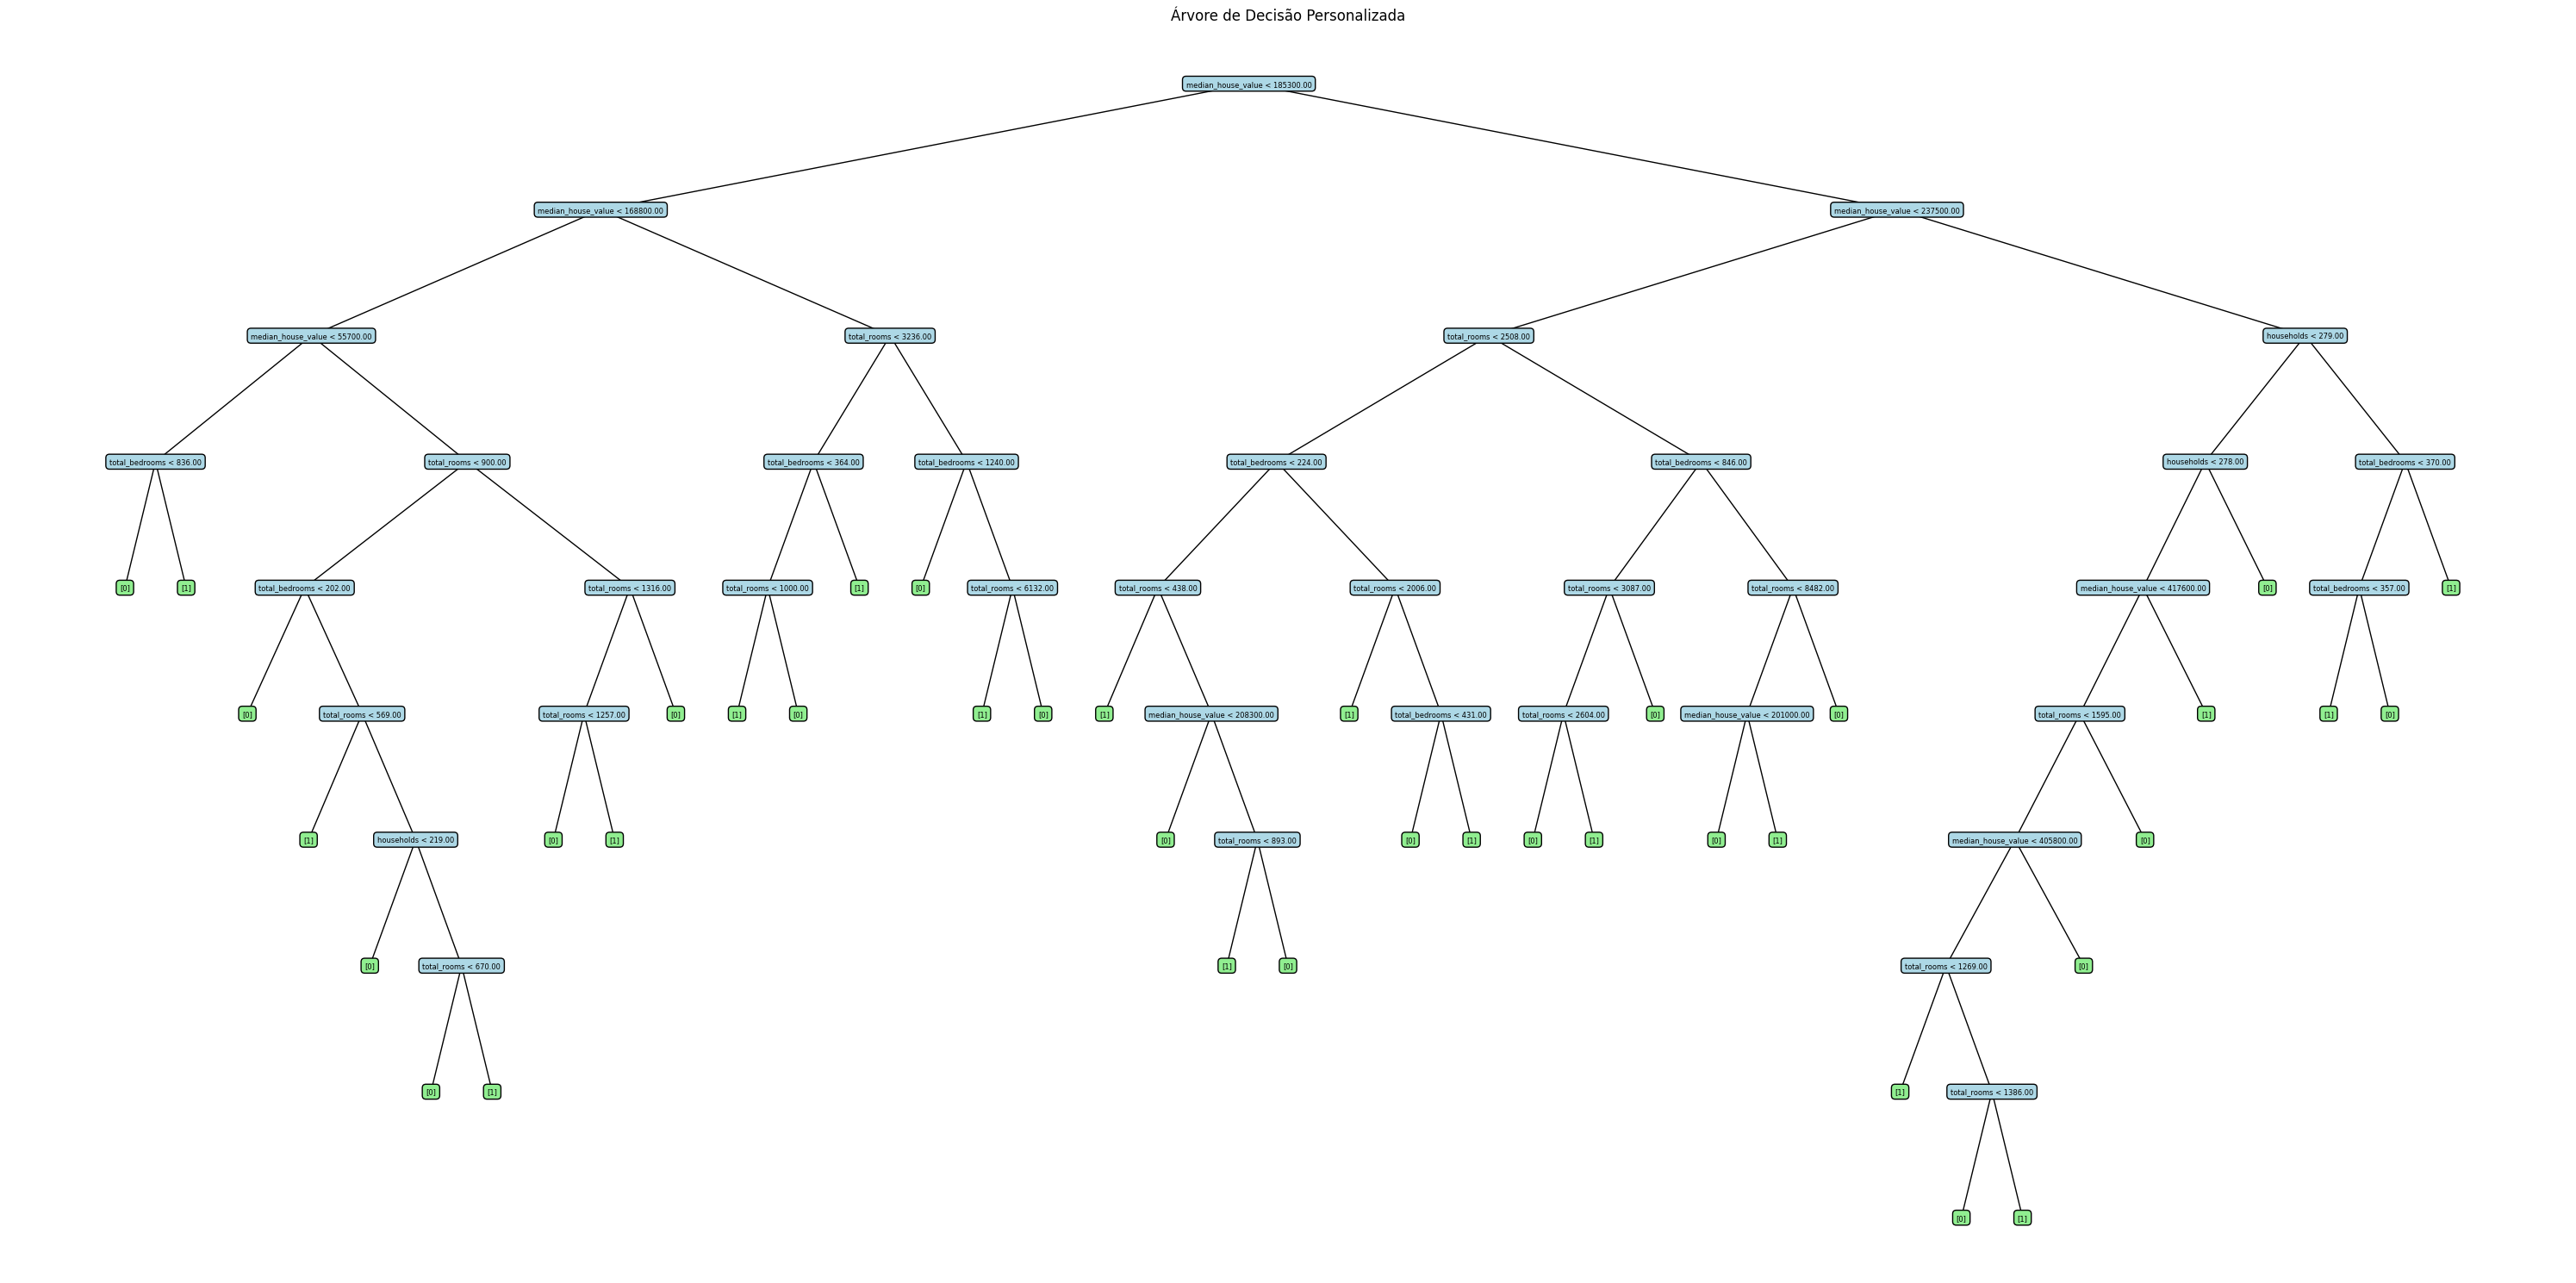

Acurácia treino antes poda: 1.0
Acurácia validação antes poda: 0.875968992248062


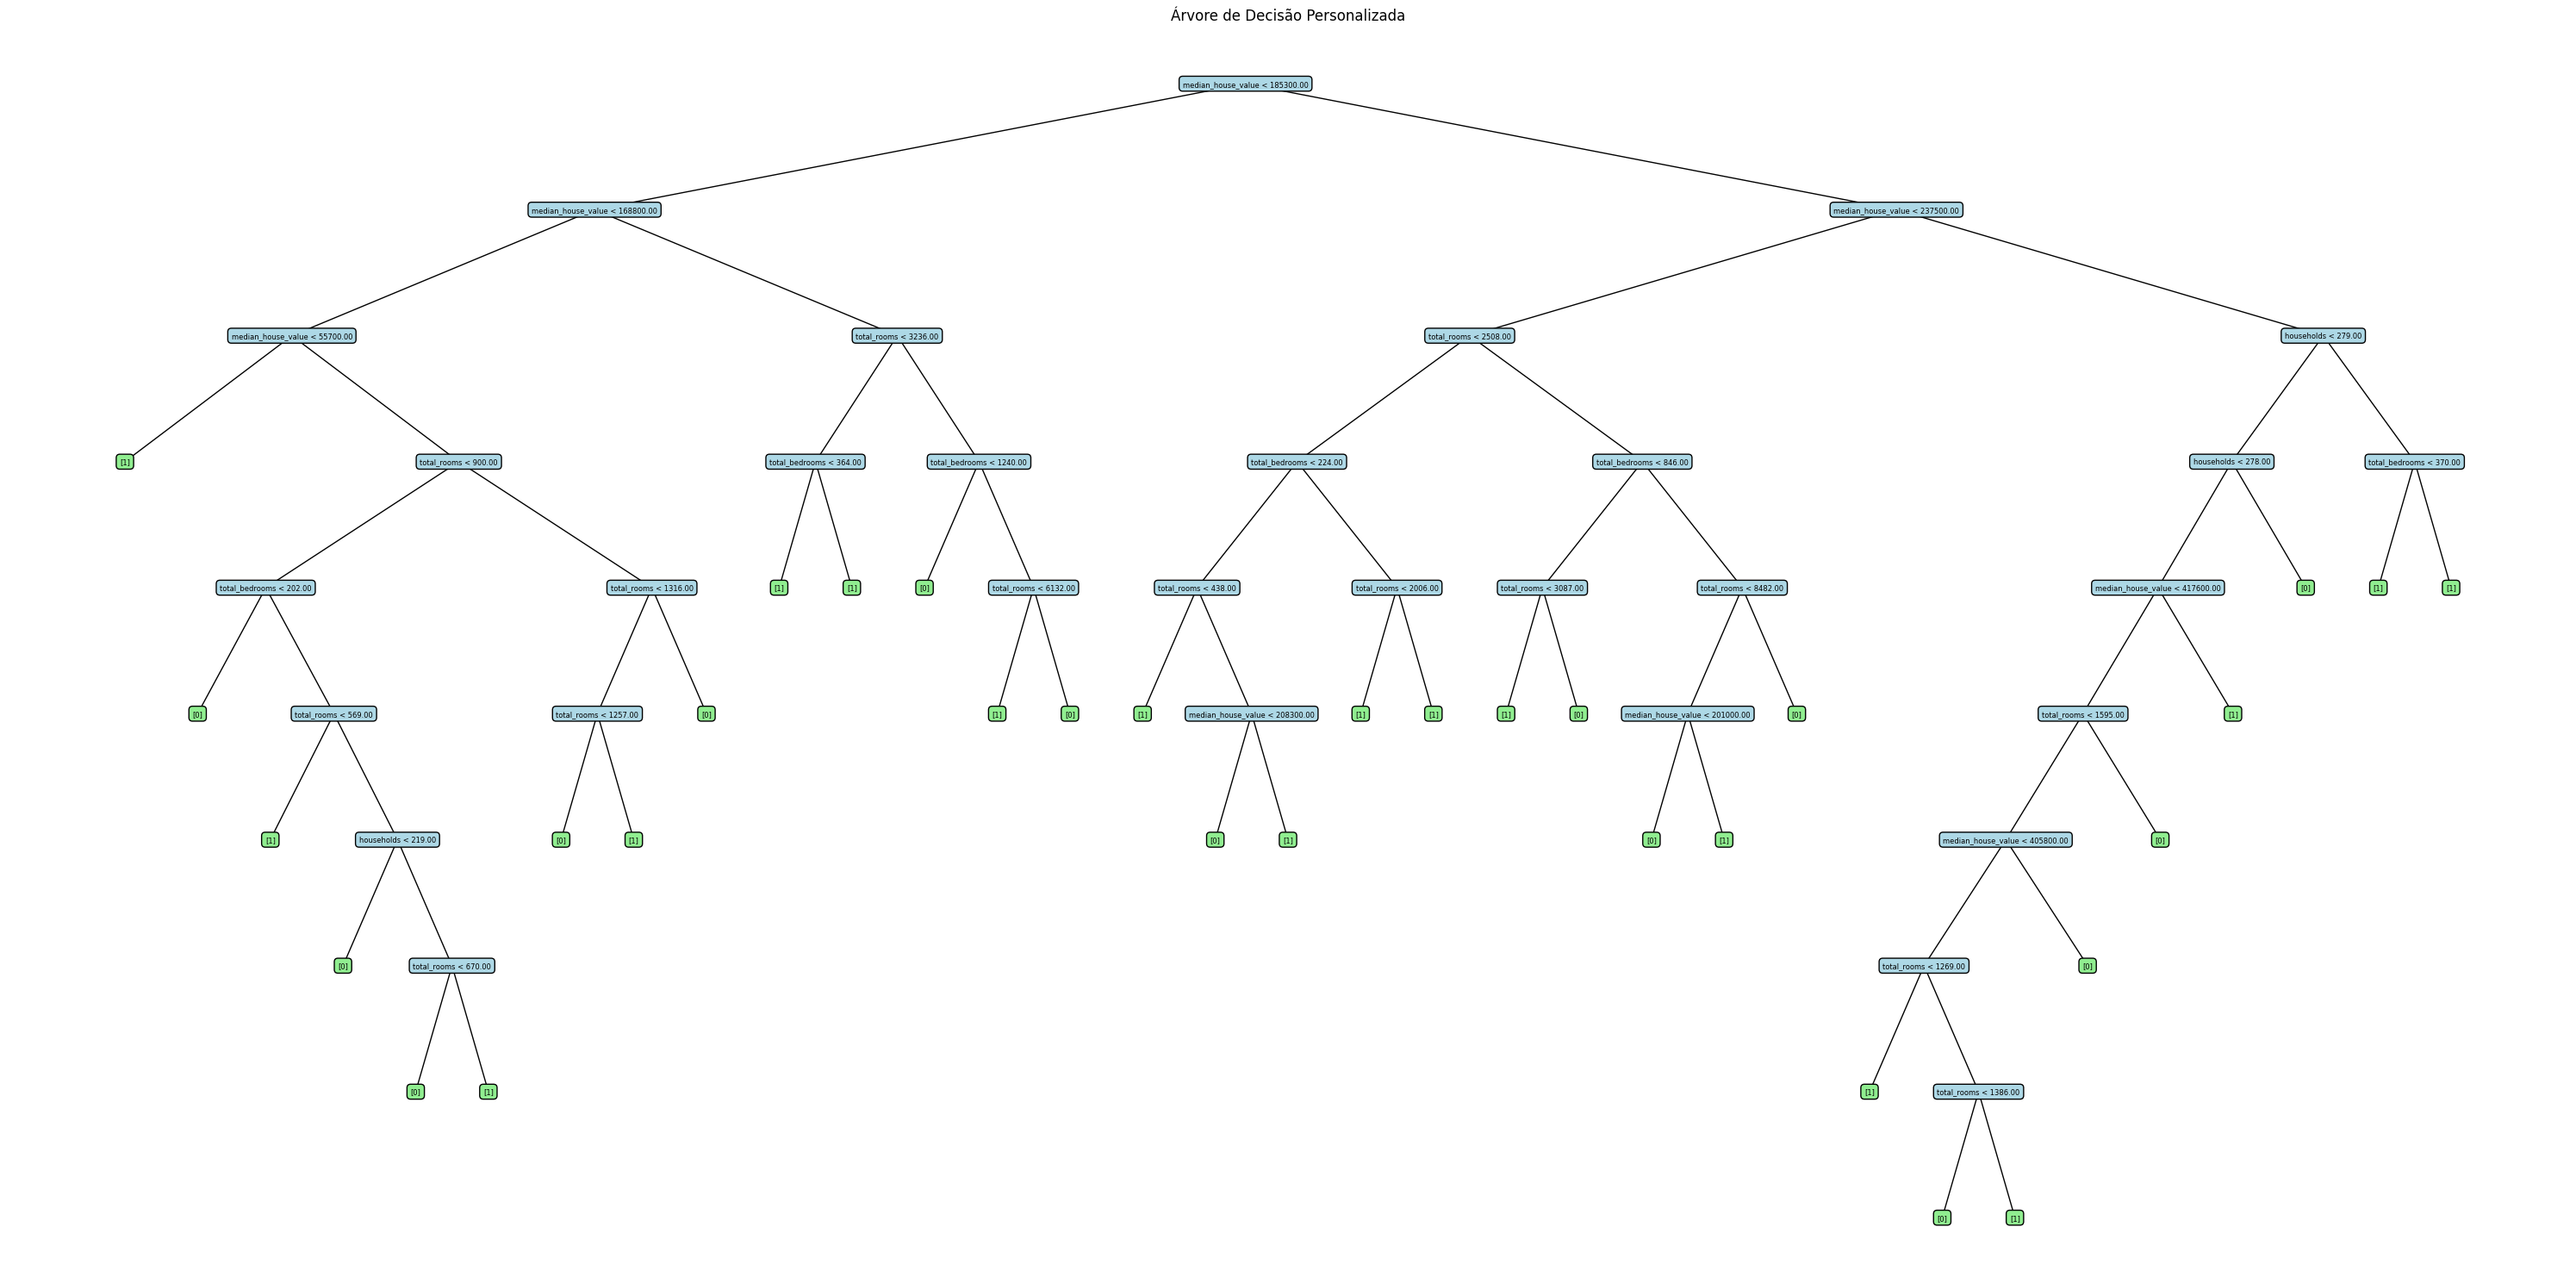

Acurácia treino após poda: 0.9766277128547579
Acurácia validação após poda: 0.9069767441860465


In [156]:
X = housing.drop(columns=["city"]).values
y = housing["city"].map({"Sacramento": 0, "San Francisco": 1}).values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=160)

# Construir árvore que cresce até pureza máxima
raiz = construir_arvore(X_train, y_train, min_samples_leaf=1)
plotar_arvore_dinamica(raiz, feature_names=["total_rooms", "total_bedrooms", "households", "median_house_value"])
raiz_completa = raiz.extrai_cortes()

print("Acurácia treino antes poda:", accuracy(raiz, X_train, y_train))
print("Acurácia validação antes poda:", accuracy(raiz, X_val, y_val))

# Poda com base na validação
podar_ate_convergir(raiz, X_val, y_val, min_ganho=0.1)
plotar_arvore_dinamica(raiz, feature_names=["total_rooms", "total_bedrooms", "households", "median_house_value"])
raiz_poda = raiz.extrai_cortes()

print("Acurácia treino após poda:", accuracy(raiz, X_train, y_train))
print("Acurácia validação após poda:", accuracy(raiz, X_val, y_val))

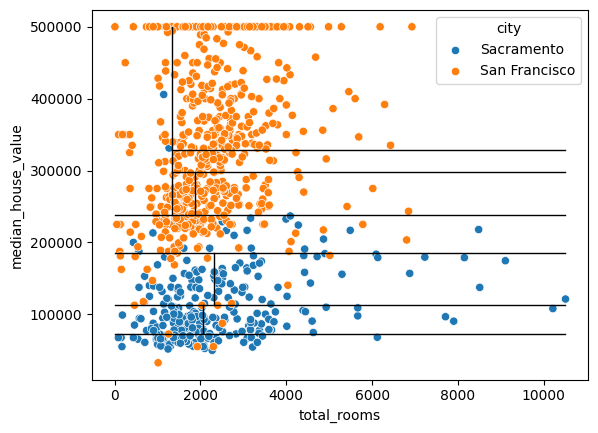

In [166]:
# dataset 2D

housing = pd.read_csv("static/data/housing_limpo.csv")
X = housing[["total_rooms", "median_house_value"]].values
y = housing["city"].map({"Sacramento": 0, "San Francisco": 1}).values

# Construir árvore que cresce até pureza máxima
raiz = construir_arvore(X, y, min_samples_leaf=50)

def subdividir(ax, bbox, corte, feature_names):
    if "class" in corte:
        return

    x0, y0, x1, y1 = bbox
    feature = corte["feature"]
    threshold = float(corte["threshold"])  # garantir que seja float normal

    if feature == feature_names[0]:  # corte vertical (x = threshold)
        ax.plot([threshold, threshold], [y0, y1], color='black', linewidth=1)
        subdividir(ax, (x0, y0, threshold, y1), corte.get("left"), feature_names)
        subdividir(ax, (threshold, y0, x1, y1), corte.get("right"), feature_names)

    elif feature == feature_names[1]:  # corte horizontal (y = threshold)
        ax.plot([x0, x1], [threshold, threshold], color='black', linewidth=1)
        subdividir(ax, (x0, y0, x1, threshold), corte.get("left"), feature_names)
        subdividir(ax, (x0, threshold, x1, y1), corte.get("right"), feature_names)

fig, ax = plt.subplots()

corte_raiz_2d = raiz.extrai_cortes(["total_rooms", "median_house_value"])
bbox = (0, 0, housing["total_rooms"].max(), housing["median_house_value"].max())

subdividir(ax, bbox, corte_raiz_2d, feature_names=["total_rooms", "median_house_value"])

df = housing#[housing["city"] == "Sacramento"]
sns.scatterplot(df, x = housing["total_rooms"], y = housing["median_house_value"], hue = "city")
plt.show()


In [158]:
# salvando a estrutura de cortes em um json
def converter(obj):
    if isinstance(obj, (np.integer, np.floating)):
        return obj.item()
    raise TypeError(f"Tipo {type(obj)} não é serializável")

# Salvar em cortes.txt (ou .json)
with open("cortes_2d.json", "w") as f:
    json.dump(corte_raiz_2d, f, default=converter, indent=2)

    # Salvar em cortes.txt (ou .json)
with open("cortes_completa.json", "w") as f:
    json.dump(raiz_completa, f, default=converter, indent=2)

with open("cortes_poda.json", "w") as f:
    json.dump(raiz_poda, f, default=converter, indent=2)

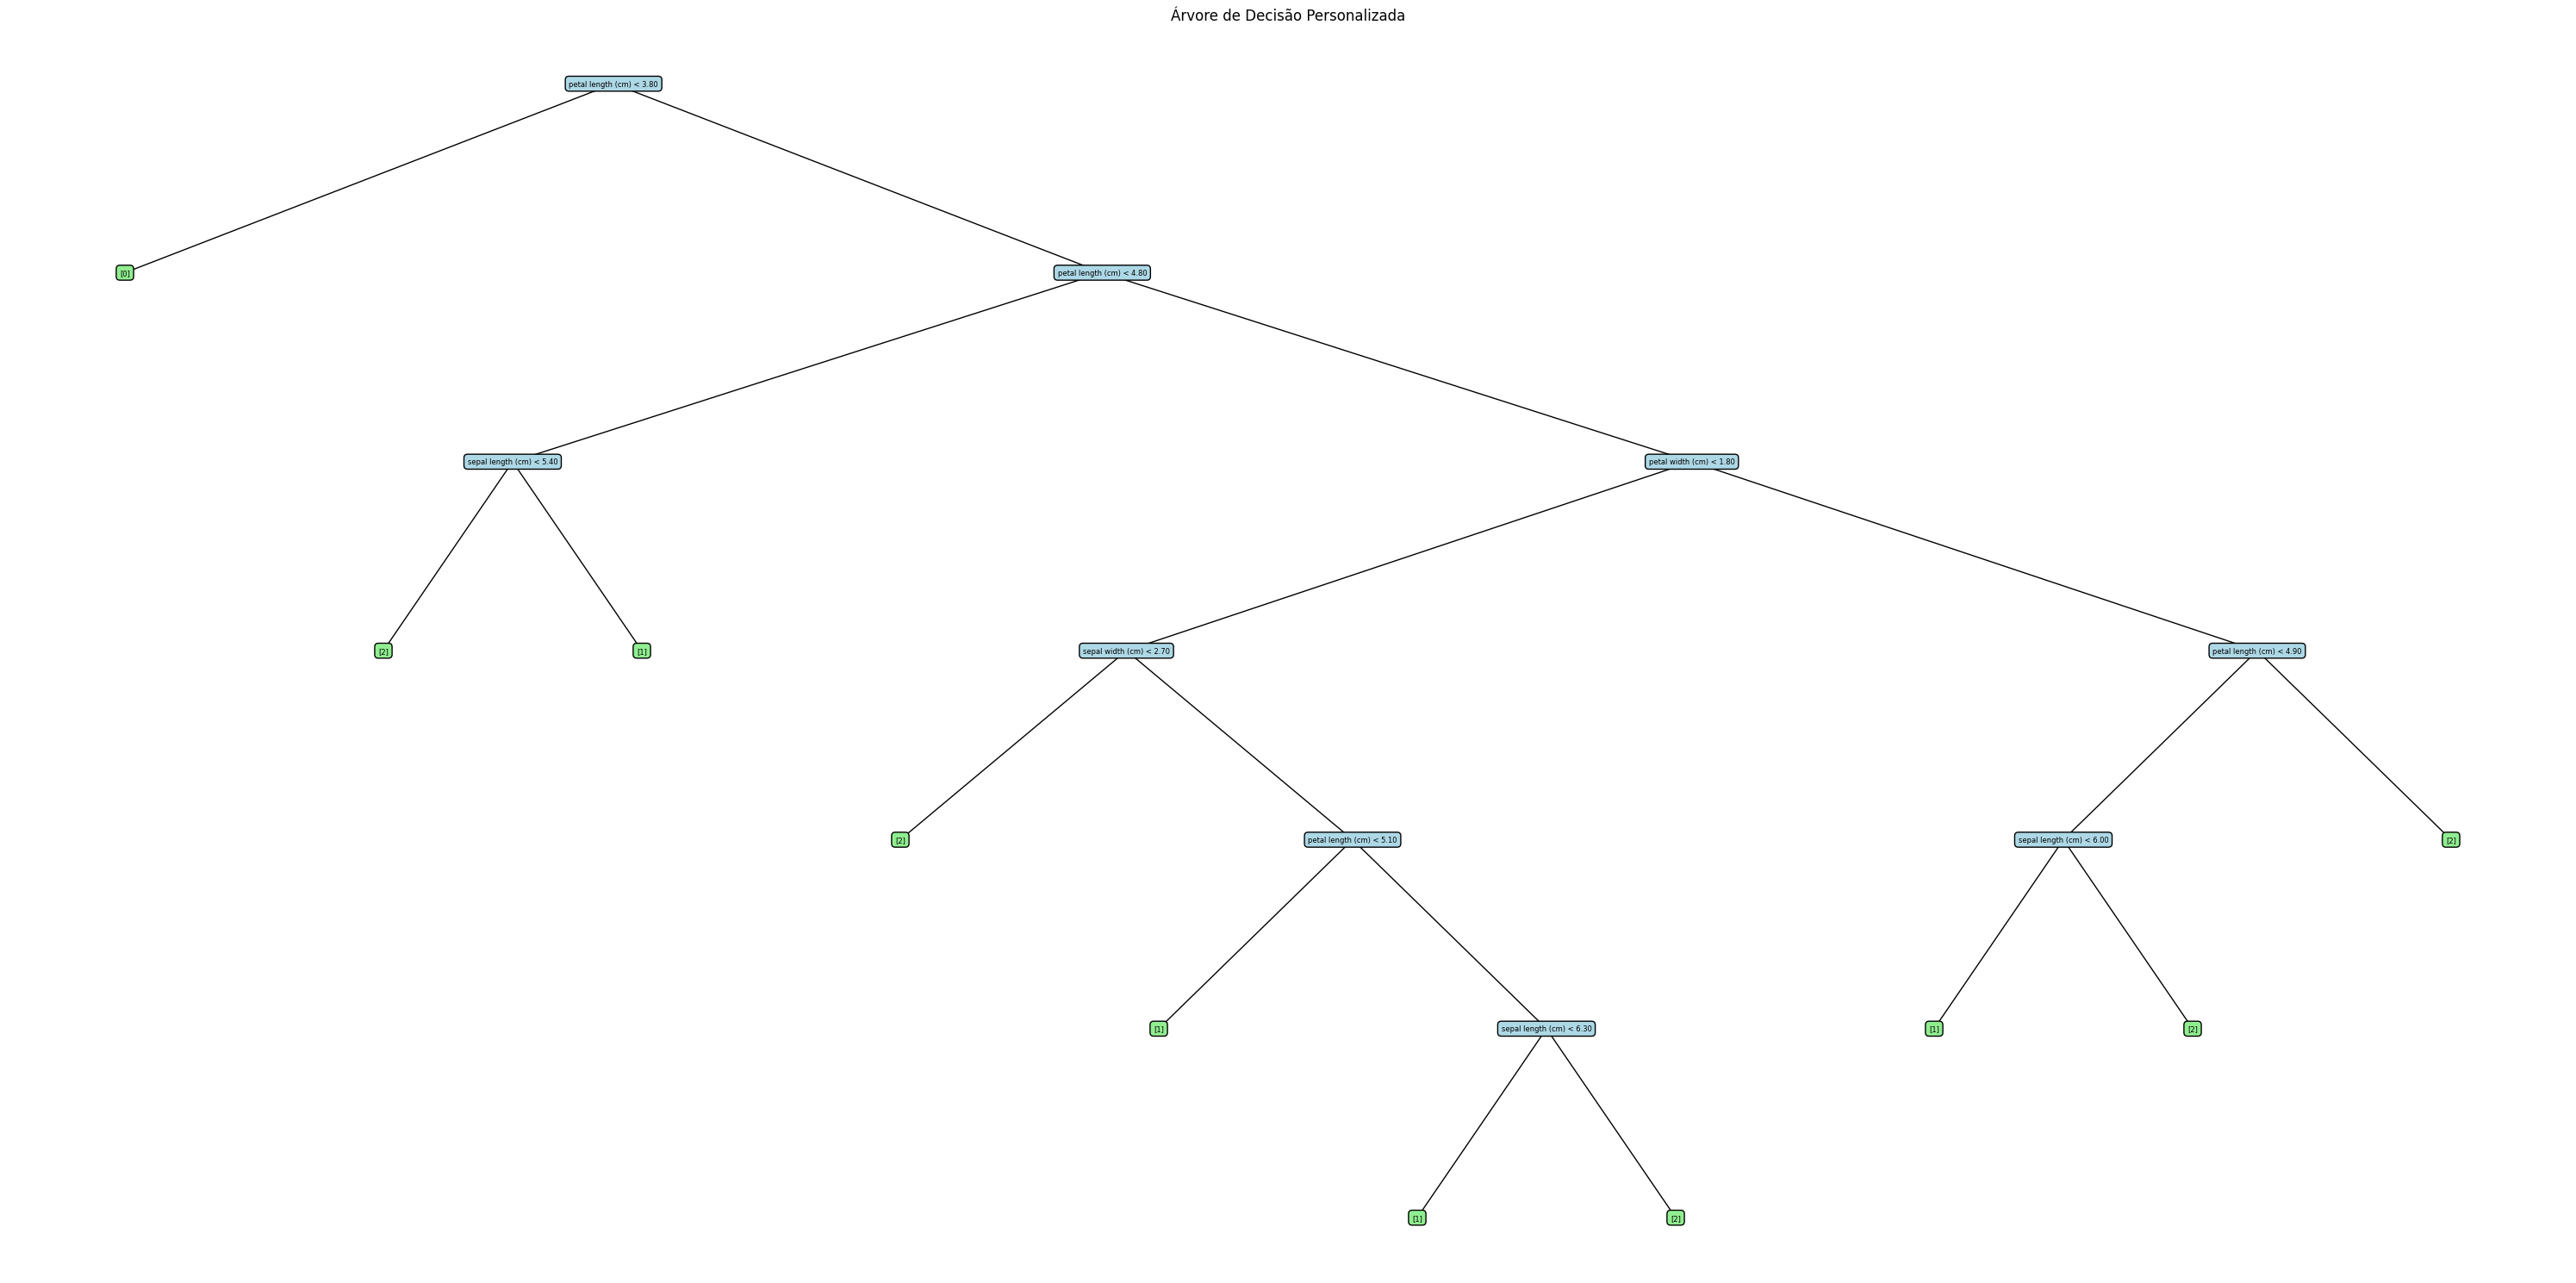

Acurácia treino antes poda: 1.0
Acurácia validação antes poda: 0.8


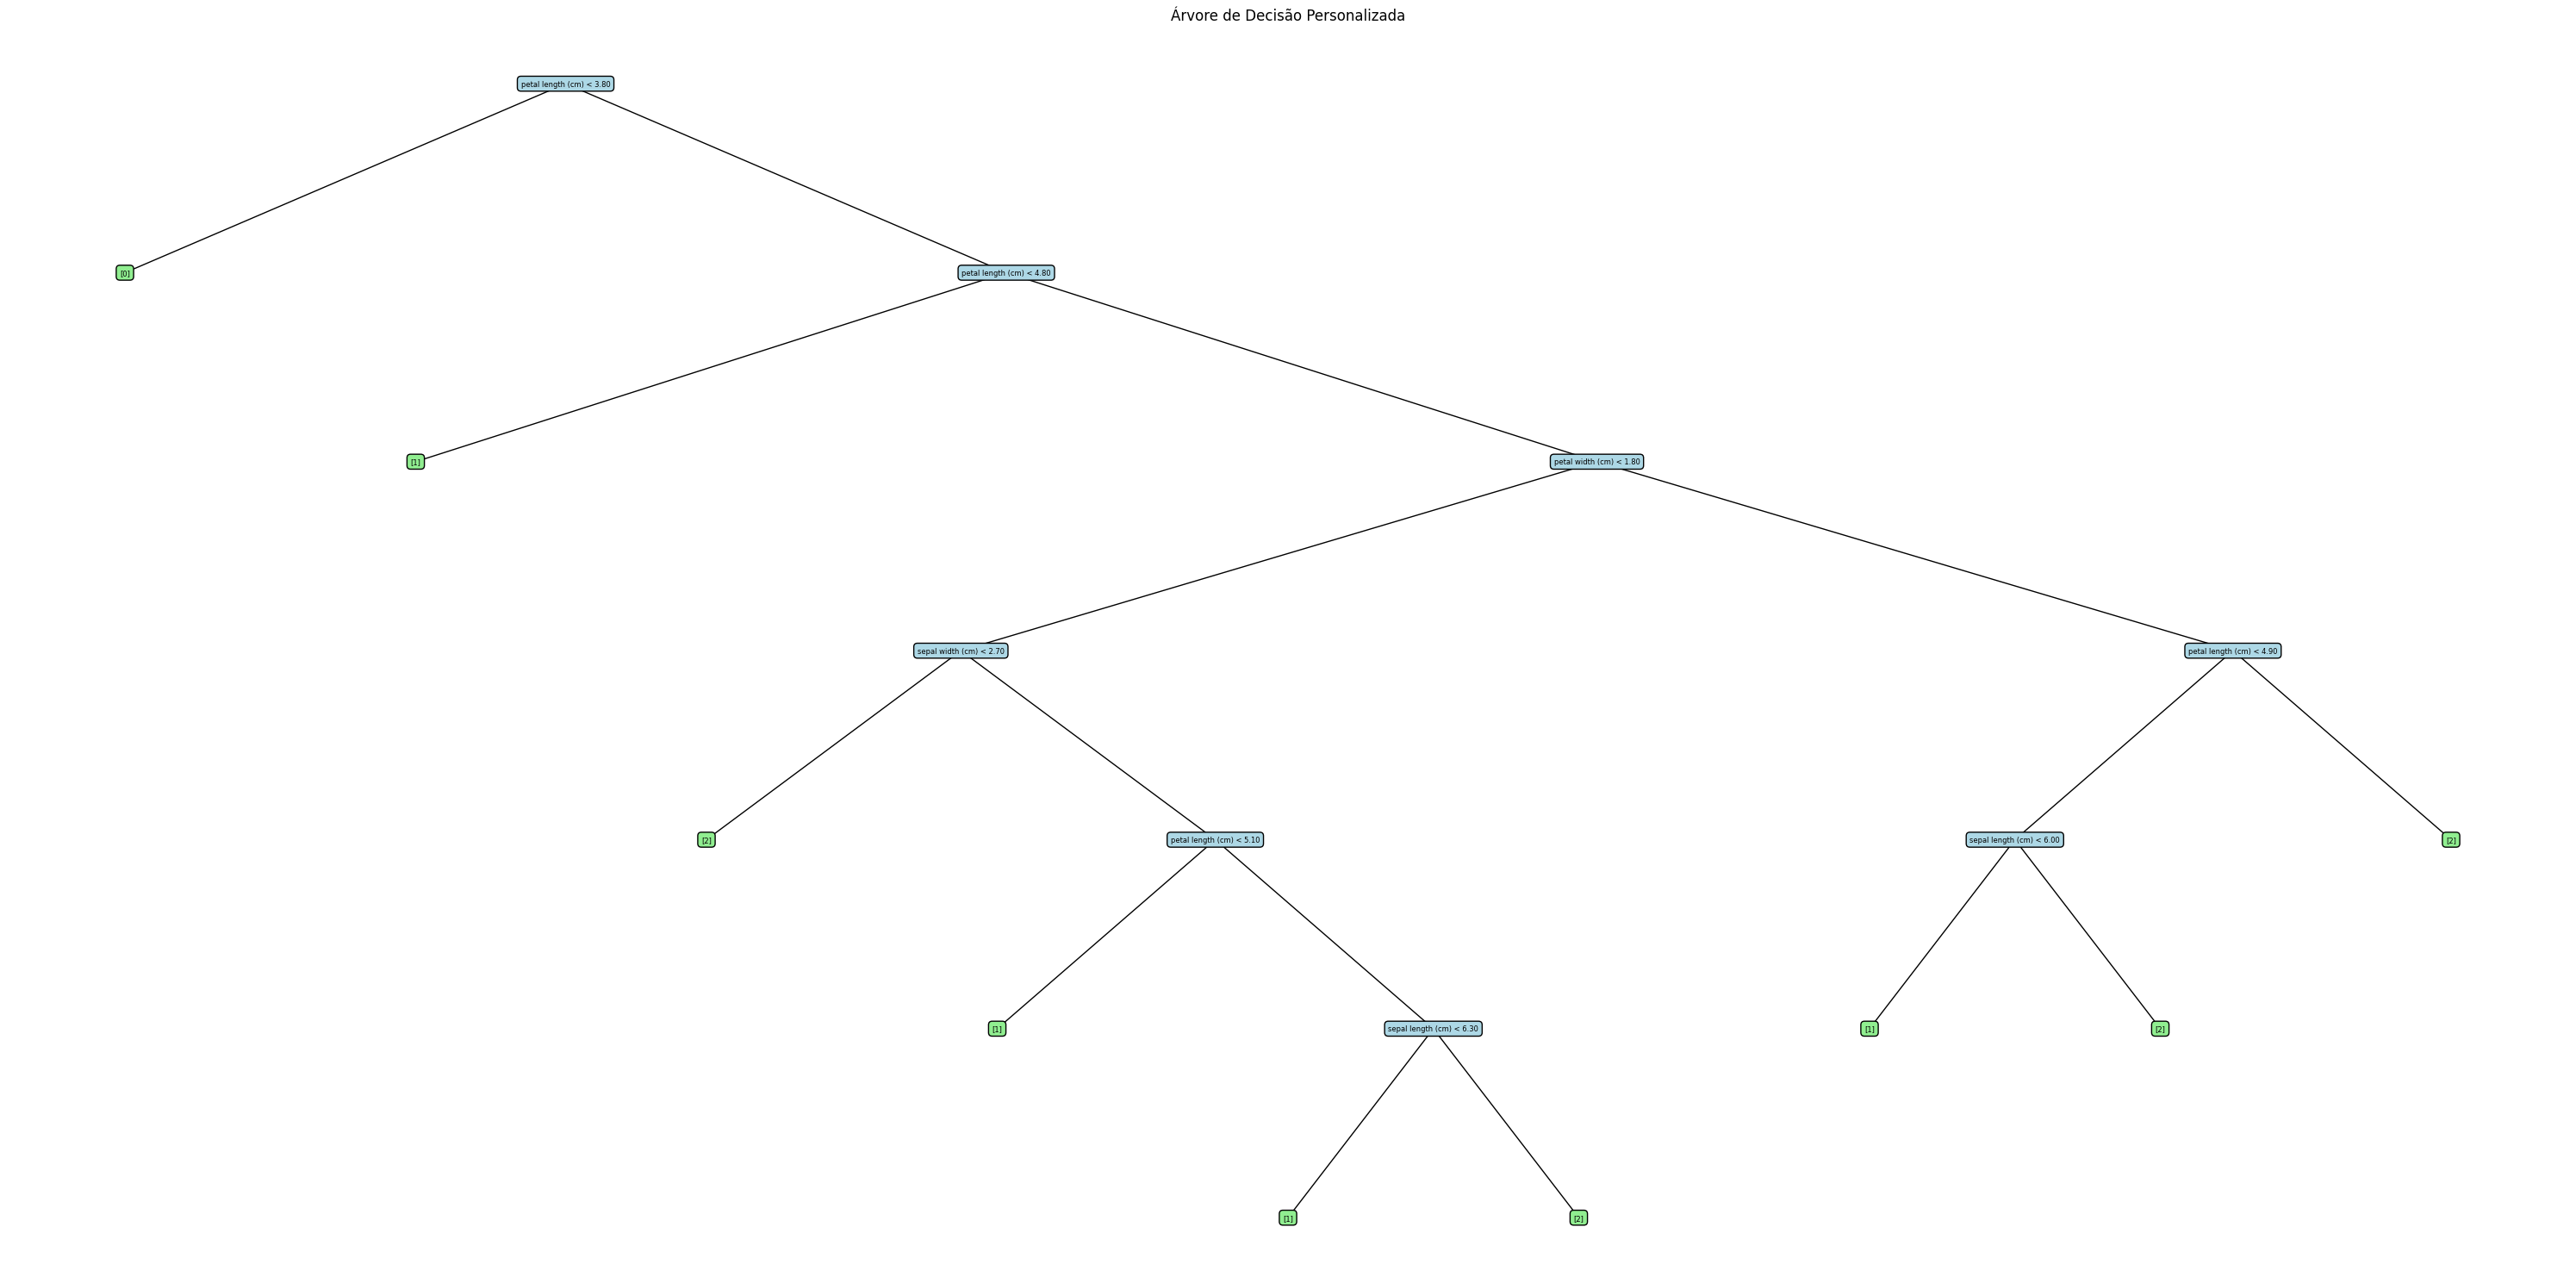

Acurácia treino após poda: 0.9904761904761905
Acurácia validação após poda: 0.8222222222222222


In [159]:
# testando com um dataset menor

iris = load_iris()
X = iris.data  
y = iris.target 
feature_names = iris.feature_names
class_names = iris.target_names


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=170)

# Construir árvore que cresce até pureza máxima
raiz = construir_arvore(X_train, y_train, min_samples_leaf=1)
plotar_arvore_dinamica(raiz, feature_names=feature_names)

print("Acurácia treino antes poda:", accuracy(raiz, X_train, y_train))
print("Acurácia validação antes poda:", accuracy(raiz, X_val, y_val))

# Poda com base na validação
podar_ate_convergir(raiz, X_val, y_val, min_ganho=0.1)
plotar_arvore_dinamica(raiz, feature_names=feature_names)

print("Acurácia treino após poda:", accuracy(raiz, X_train, y_train))
print("Acurácia validação após poda:", accuracy(raiz, X_val, y_val))

# Criando json

In [167]:
def cortes_para_json(corte, feature_names):
    if "class" in corte:
        return {
            "name": f"Classe: {corte['class']}"
        }

    feature_idx = int(corte["feature"].split()[-1])

    if feature_idx >= len(feature_names):
        feature_name = f"{feature_names}"  # fallback
    else:
        feature_name = feature_names[feature_idx]

    threshold = float(corte["threshold"])

    return {
        "name": f"{feature_name} ≤ {threshold:.2f}",
        "children": [
            cortes_para_json(corte["left"], feature_names),
            cortes_para_json(corte["right"], feature_names)
        ]
    }


In [168]:
feature_names = ["total_bedrooms", "median_house_value"]  # ou as colunas de X
corte_raiz_2d = raiz.extrai_cortes()
arvore_json = cortes_para_json(corte_raiz_2d, feature_names)

with open("arvore_d3.json", "w") as f:
    json.dump(arvore_json, f, indent=2)


In [34]:
# Implementação de diferentes tipos de poda (pruning)

# 1. PODA POR VALIDAÇÃO (já implementada, mas melhorada)
def poda_validacao_melhorada(no, X_val, y_val, min_ganho=0.01):
    """Poda baseada na melhoria da acurácia no conjunto de validação"""
    if no.is_leaf:
        return False, 0
    
    podou_esq, ganho_esq = poda_validacao_melhorada(no.left, X_val, y_val, min_ganho)
    podou_dir, ganho_dir = poda_validacao_melhorada(no.right, X_val, y_val, min_ganho)
    
    # Tenta podar se ambos filhos são folhas
    if no.left and no.right and no.left.is_leaf and no.right.is_leaf:
        acc_antes = accuracy(no, X_val, y_val)
        
        # Backup do estado atual
        backup = (no.is_leaf, no.predicted_class, no.feature, no.threshold, no.left, no.right)
        
        # Converte para folha
        no.is_leaf = True
        no.feature = None
        no.threshold = None
        no.left = None
        no.right = None
        
        acc_depois = accuracy(no, X_val, y_val)
        ganho = acc_depois - acc_antes
        
        if ganho >= min_ganho:
            return True, ganho
        else:
            # Restaura estado
            no.is_leaf, no.predicted_class, no.feature, no.threshold, no.left, no.right = backup
            return podou_esq or podou_dir, max(ganho_esq, ganho_dir)
    
    return podou_esq or podou_dir, max(ganho_esq, ganho_dir)

# 2. PODA POR CUSTO-COMPLEXIDADE (Cost-Complexity Pruning / Minimal Cost-Complexity)
def calcular_custo_complexidade(no, alpha):
    """Calcula o custo-complexidade de um nó"""
    if no.is_leaf:
        return no.impurity * no.samples
    
    # Custo como folha
    custo_folha = no.impurity * no.samples + alpha
    
    # Custo como nó interno
    custo_esq = calcular_custo_complexidade(no.left, alpha)
    custo_dir = calcular_custo_complexidade(no.right, alpha)
    custo_interno = custo_esq + custo_dir + alpha
    
    return min(custo_folha, custo_interno)

def poda_custo_complexidade(no, alpha):
    """Poda baseada no custo-complexidade com parâmetro alpha"""
    if no.is_leaf:
        return False
    
    # Poda recursivamente os filhos primeiro
    podou_esq = poda_custo_complexidade(no.left, alpha)
    podou_dir = poda_custo_complexidade(no.right, alpha)
    
    # Calcula custos
    custo_folha = no.impurity * no.samples + alpha
    custo_esq = calcular_custo_complexidade(no.left, alpha)
    custo_dir = calcular_custo_complexidade(no.right, alpha)
    custo_interno = custo_esq + custo_dir + alpha
    
    # Poda se for mais barato ser folha
    if custo_folha <= custo_interno:
        no.is_leaf = True
        no.feature = None
        no.threshold = None
        no.left = None
        no.right = None
        return True
    
    return podou_esq or podou_dir

# 3. PODA POR PROFUNDIDADE
def poda_profundidade(no, max_depth, depth_atual=0):
    """Poda baseada na profundidade máxima"""
    if no.is_leaf or depth_atual >= max_depth:
        if not no.is_leaf:
            # Converte para folha
            no.is_leaf = True
            no.feature = None
            no.threshold = None
            no.left = None
            no.right = None
        return True
    
    podou_esq = poda_profundidade(no.left, max_depth, depth_atual + 1)
    podou_dir = poda_profundidade(no.right, max_depth, depth_atual + 1)
    
    return podou_esq or podou_dir

# 4. PODA POR TAMANHO MÍNIMO DE NÓS
def poda_tamanho_minimo(no, min_samples):
    """Poda nós com menos amostras que o mínimo"""
    if no.is_leaf:
        return False
    
    podou_esq = poda_tamanho_minimo(no.left, min_samples)
    podou_dir = poda_tamanho_minimo(no.right, min_samples)
    
    # Poda se algum filho tem poucas amostras
    if (no.left and no.left.samples < min_samples) or (no.right and no.right.samples < min_samples):
        no.is_leaf = True
        no.feature = None
        no.threshold = None
        no.left = None
        no.right = None
        return True
    
    return podou_esq or podou_dir

# 5. PODA HÍBRIDA (combina múltiplos critérios)
def poda_hibrida(no, X_val, y_val, alpha=0.01, max_depth=5, min_samples=10):
    """Aplica múltiplos tipos de poda em sequência"""
    # Primeiro: poda por profundidade
    poda_profundidade(no, max_depth)
    
    # Segundo: poda por tamanho mínimo
    poda_tamanho_minimo(no, min_samples)
    
    # Terceiro: poda por custo-complexidade
    poda_custo_complexidade(no, alpha)
    
    # Quarto: poda por validação
    poda_validacao_melhorada(no, X_val, y_val)

# Função para salvar diferentes tipos de árvores podadas
def salvar_arvores_podadas(X_train, y_train, X_val, y_val, feature_names, prefixo="arvore"):
    """Gera e salva múltiplas versões podadas da árvore"""
    arvores = {}
    
    # Árvore original (sem poda)
    raiz_original = construir_arvore(X_train, y_train, min_samples_leaf=1)
    arvores['original'] = {
        'tree': raiz_original,
        'cortes': raiz_original.extrai_cortes(feature_names),
        'acc_train': accuracy(raiz_original, X_train, y_train),
        'acc_val': accuracy(raiz_original, X_val, y_val)
    }
    
    # Poda por validação
    raiz_val = construir_arvore(X_train, y_train, min_samples_leaf=1)
    poda_validacao_melhorada(raiz_val, X_val, y_val, min_ganho=0.01)
    arvores['validacao'] = {
        'tree': raiz_val,
        'cortes': raiz_val.extrai_cortes(feature_names),
        'acc_train': accuracy(raiz_val, X_train, y_train),
        'acc_val': accuracy(raiz_val, X_val, y_val)
    }
    
    # Poda por custo-complexidade (diferentes alphas)
    for alpha in [0.001, 0.01, 0.1]:
        raiz_cc = construir_arvore(X_train, y_train, min_samples_leaf=1)
        poda_custo_complexidade(raiz_cc, alpha)
        arvores[f'custo_complexidade_alpha_{alpha}'] = {
            'tree': raiz_cc,
            'cortes': raiz_cc.extrai_cortes(feature_names),
            'acc_train': accuracy(raiz_cc, X_train, y_train),
            'acc_val': accuracy(raiz_cc, X_val, y_val)
        }
    
    # Poda por profundidade
    for depth in [2, 3, 4, 5]:
        raiz_prof = construir_arvore(X_train, y_train, min_samples_leaf=1)
        poda_profundidade(raiz_prof, depth)
        arvores[f'profundidade_{depth}'] = {
            'tree': raiz_prof,
            'cortes': raiz_prof.extrai_cortes(feature_names),
            'acc_train': accuracy(raiz_prof, X_train, y_train),
            'acc_val': accuracy(raiz_prof, X_val, y_val)
        }
    
    # Poda híbrida
    raiz_hibrida = construir_arvore(X_train, y_train, min_samples_leaf=1)
    poda_hibrida(raiz_hibrida, X_val, y_val)
    arvores['hibrida'] = {
        'tree': raiz_hibrida,
        'cortes': raiz_hibrida.extrai_cortes(feature_names),
        'acc_train': accuracy(raiz_hibrida, X_train, y_train),
        'acc_val': accuracy(raiz_hibrida, X_val, y_val)
    }
    
    # Salvar JSONs
    for nome, dados in arvores.items():
        filename = f"{prefixo}_{nome}.json"
        with open(filename, "w") as f:
            json.dump(dados['cortes'], f, default=converter, indent=2)
        print(f"Salvo: {filename} - Train Acc: {dados['acc_train']:.3f}, Val Acc: {dados['acc_val']:.3f}")
    
    return arvores

print("Implementações de poda carregadas com sucesso!")
print("Métodos disponíveis:")
print("1. poda_validacao_melhorada() - Poda por validação")
print("2. poda_custo_complexidade() - Poda por custo-complexidade")
print("3. poda_profundidade() - Poda por profundidade máxima")
print("4. poda_tamanho_minimo() - Poda por tamanho mínimo de nós")
print("5. poda_hibrida() - Poda híbrida (combinada)")
print("6. salvar_arvores_podadas() - Gera e salva múltiplas versões")

Implementações de poda carregadas com sucesso!
Métodos disponíveis:
1. poda_validacao_melhorada() - Poda por validação
2. poda_custo_complexidade() - Poda por custo-complexidade
3. poda_profundidade() - Poda por profundidade máxima
4. poda_tamanho_minimo() - Poda por tamanho mínimo de nós
5. poda_hibrida() - Poda híbrida (combinada)
6. salvar_arvores_podadas() - Gera e salva múltiplas versões


In [35]:
# Demonstração dos diferentes métodos de poda com o dataset de housing

# Preparar dados
housing = pd.read_csv("data/housing_limpo.csv")
X = housing.drop(columns=["city", "Unnamed: 0"]).values
y = housing["city"].map({"Sacramento": 0, "San Francisco": 1}).values
feature_names = ["total_rooms", "total_bedrooms", "households", "median_house_value"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=160)

print("=== COMPARAÇÃO DE MÉTODOS DE PODA ===")
print(f"Tamanho treino: {len(X_train)}, Tamanho validação: {len(X_val)}")
print("\n" + "="*60)

# 1. Árvore original (sem poda)
print("\n1. ÁRVORE ORIGINAL (SEM PODA)")
raiz_original = construir_arvore(X_train, y_train, min_samples_leaf=1)
acc_train_orig = accuracy(raiz_original, X_train, y_train)
acc_val_orig = accuracy(raiz_original, X_val, y_val)
print(f"Acurácia Treino: {acc_train_orig:.3f}")
print(f"Acurácia Validação: {acc_val_orig:.3f}")

# 2. Poda por validação
print("\n2. PODA POR VALIDAÇÃO")
raiz_val = construir_arvore(X_train, y_train, min_samples_leaf=1)
podou, ganho = poda_validacao_melhorada(raiz_val, X_val, y_val, min_ganho=0.01)
acc_train_val = accuracy(raiz_val, X_train, y_train)
acc_val_val = accuracy(raiz_val, X_val, y_val)
print(f"Podou: {podou}, Ganho: {ganho:.3f}")
print(f"Acurácia Treino: {acc_train_val:.3f}")
print(f"Acurácia Validação: {acc_val_val:.3f}")

# 3. Poda por custo-complexidade
print("\n3. PODA POR CUSTO-COMPLEXIDADE")
for alpha in [0.001, 0.01, 0.1]:
    raiz_cc = construir_arvore(X_train, y_train, min_samples_leaf=1)
    podou_cc = poda_custo_complexidade(raiz_cc, alpha)
    acc_train_cc = accuracy(raiz_cc, X_train, y_train)
    acc_val_cc = accuracy(raiz_cc, X_val, y_val)
    print(f"Alpha {alpha}: Podou: {podou_cc}, Train: {acc_train_cc:.3f}, Val: {acc_val_cc:.3f}")

# 4. Poda por profundidade
print("\n4. PODA POR PROFUNDIDADE")
for depth in [2, 3, 4, 5]:
    raiz_prof = construir_arvore(X_train, y_train, min_samples_leaf=1)
    podou_prof = poda_profundidade(raiz_prof, depth)
    acc_train_prof = accuracy(raiz_prof, X_train, y_train)
    acc_val_prof = accuracy(raiz_prof, X_val, y_val)
    print(f"Profundidade {depth}: Podou: {podou_prof}, Train: {acc_train_prof:.3f}, Val: {acc_val_prof:.3f}")

# 5. Poda por tamanho mínimo
print("\n5. PODA POR TAMANHO MÍNIMO")
for min_samples in [5, 10, 20, 50]:
    raiz_min = construir_arvore(X_train, y_train, min_samples_leaf=1)
    podou_min = poda_tamanho_minimo(raiz_min, min_samples)
    acc_train_min = accuracy(raiz_min, X_train, y_train)
    acc_val_min = accuracy(raiz_min, X_val, y_val)
    print(f"Min samples {min_samples}: Podou: {podou_min}, Train: {acc_train_min:.3f}, Val: {acc_val_min:.3f}")

# 6. Poda híbrida
print("\n6. PODA HÍBRIDA")
raiz_hibrida = construir_arvore(X_train, y_train, min_samples_leaf=1)
poda_hibrida(raiz_hibrida, X_val, y_val, alpha=0.01, max_depth=4, min_samples=10)
acc_train_hibrida = accuracy(raiz_hibrida, X_train, y_train)
acc_val_hibrida = accuracy(raiz_hibrida, X_val, y_val)
print(f"Acurácia Treino: {acc_train_hibrida:.3f}")
print(f"Acurácia Validação: {acc_val_hibrida:.3f}")

print("\n" + "="*60)
print("RESUMO COMPARATIVO:")
print(f"Original:     Train={acc_train_orig:.3f}, Val={acc_val_orig:.3f}")
print(f"Validação:    Train={acc_train_val:.3f}, Val={acc_val_val:.3f}")
print(f"Híbrida:      Train={acc_train_hibrida:.3f}, Val={acc_val_hibrida:.3f}")

=== COMPARAÇÃO DE MÉTODOS DE PODA ===
Tamanho treino: 599, Tamanho validação: 258


1. ÁRVORE ORIGINAL (SEM PODA)
Acurácia Treino: 1.000
Acurácia Validação: 0.876

2. PODA POR VALIDAÇÃO
Podou: True, Ganho: 0.395
Acurácia Treino: 0.990
Acurácia Validação: 0.919

3. PODA POR CUSTO-COMPLEXIDADE
Alpha 0.001: Podou: True, Train: 0.975, Val: 0.930
Alpha 0.01: Podou: True, Train: 0.975, Val: 0.930
Alpha 0.1: Podou: True, Train: 0.975, Val: 0.930

4. PODA POR PROFUNDIDADE
Profundidade 2: Podou: True, Train: 0.945, Val: 0.950
Profundidade 3: Podou: True, Train: 0.953, Val: 0.942
Profundidade 4: Podou: True, Train: 0.965, Val: 0.946
Profundidade 5: Podou: True, Train: 0.977, Val: 0.915

5. PODA POR TAMANHO MÍNIMO
Min samples 5: Podou: True, Train: 0.958, Val: 0.946
Min samples 10: Podou: True, Train: 0.950, Val: 0.946
Min samples 20: Podou: True, Train: 0.945, Val: 0.950
Min samples 50: Podou: True, Train: 0.945, Val: 0.950

6. PODA HÍBRIDA
Acurácia Treino: 0.945
Acurácia Validação: 0.950

RESUM


=== GERANDO E SALVANDO ÁRVORES PODADAS ===
Salvo: housing_original.json - Train Acc: 1.000, Val Acc: 0.876
Salvo: housing_validacao.json - Train Acc: 0.990, Val Acc: 0.919
Salvo: housing_custo_complexidade_alpha_0.001.json - Train Acc: 0.975, Val Acc: 0.930
Salvo: housing_custo_complexidade_alpha_0.01.json - Train Acc: 0.975, Val Acc: 0.930
Salvo: housing_custo_complexidade_alpha_0.1.json - Train Acc: 0.975, Val Acc: 0.930
Salvo: housing_profundidade_2.json - Train Acc: 0.945, Val Acc: 0.950
Salvo: housing_profundidade_3.json - Train Acc: 0.953, Val Acc: 0.942
Salvo: housing_profundidade_4.json - Train Acc: 0.965, Val Acc: 0.946
Salvo: housing_profundidade_5.json - Train Acc: 0.977, Val Acc: 0.915
Salvo: housing_hibrida.json - Train Acc: 0.945, Val Acc: 0.950

=== VISUALIZANDO ALGUMAS ÁRVORES PODADAS ===

Árvore com Poda por Profundidade (depth=3):


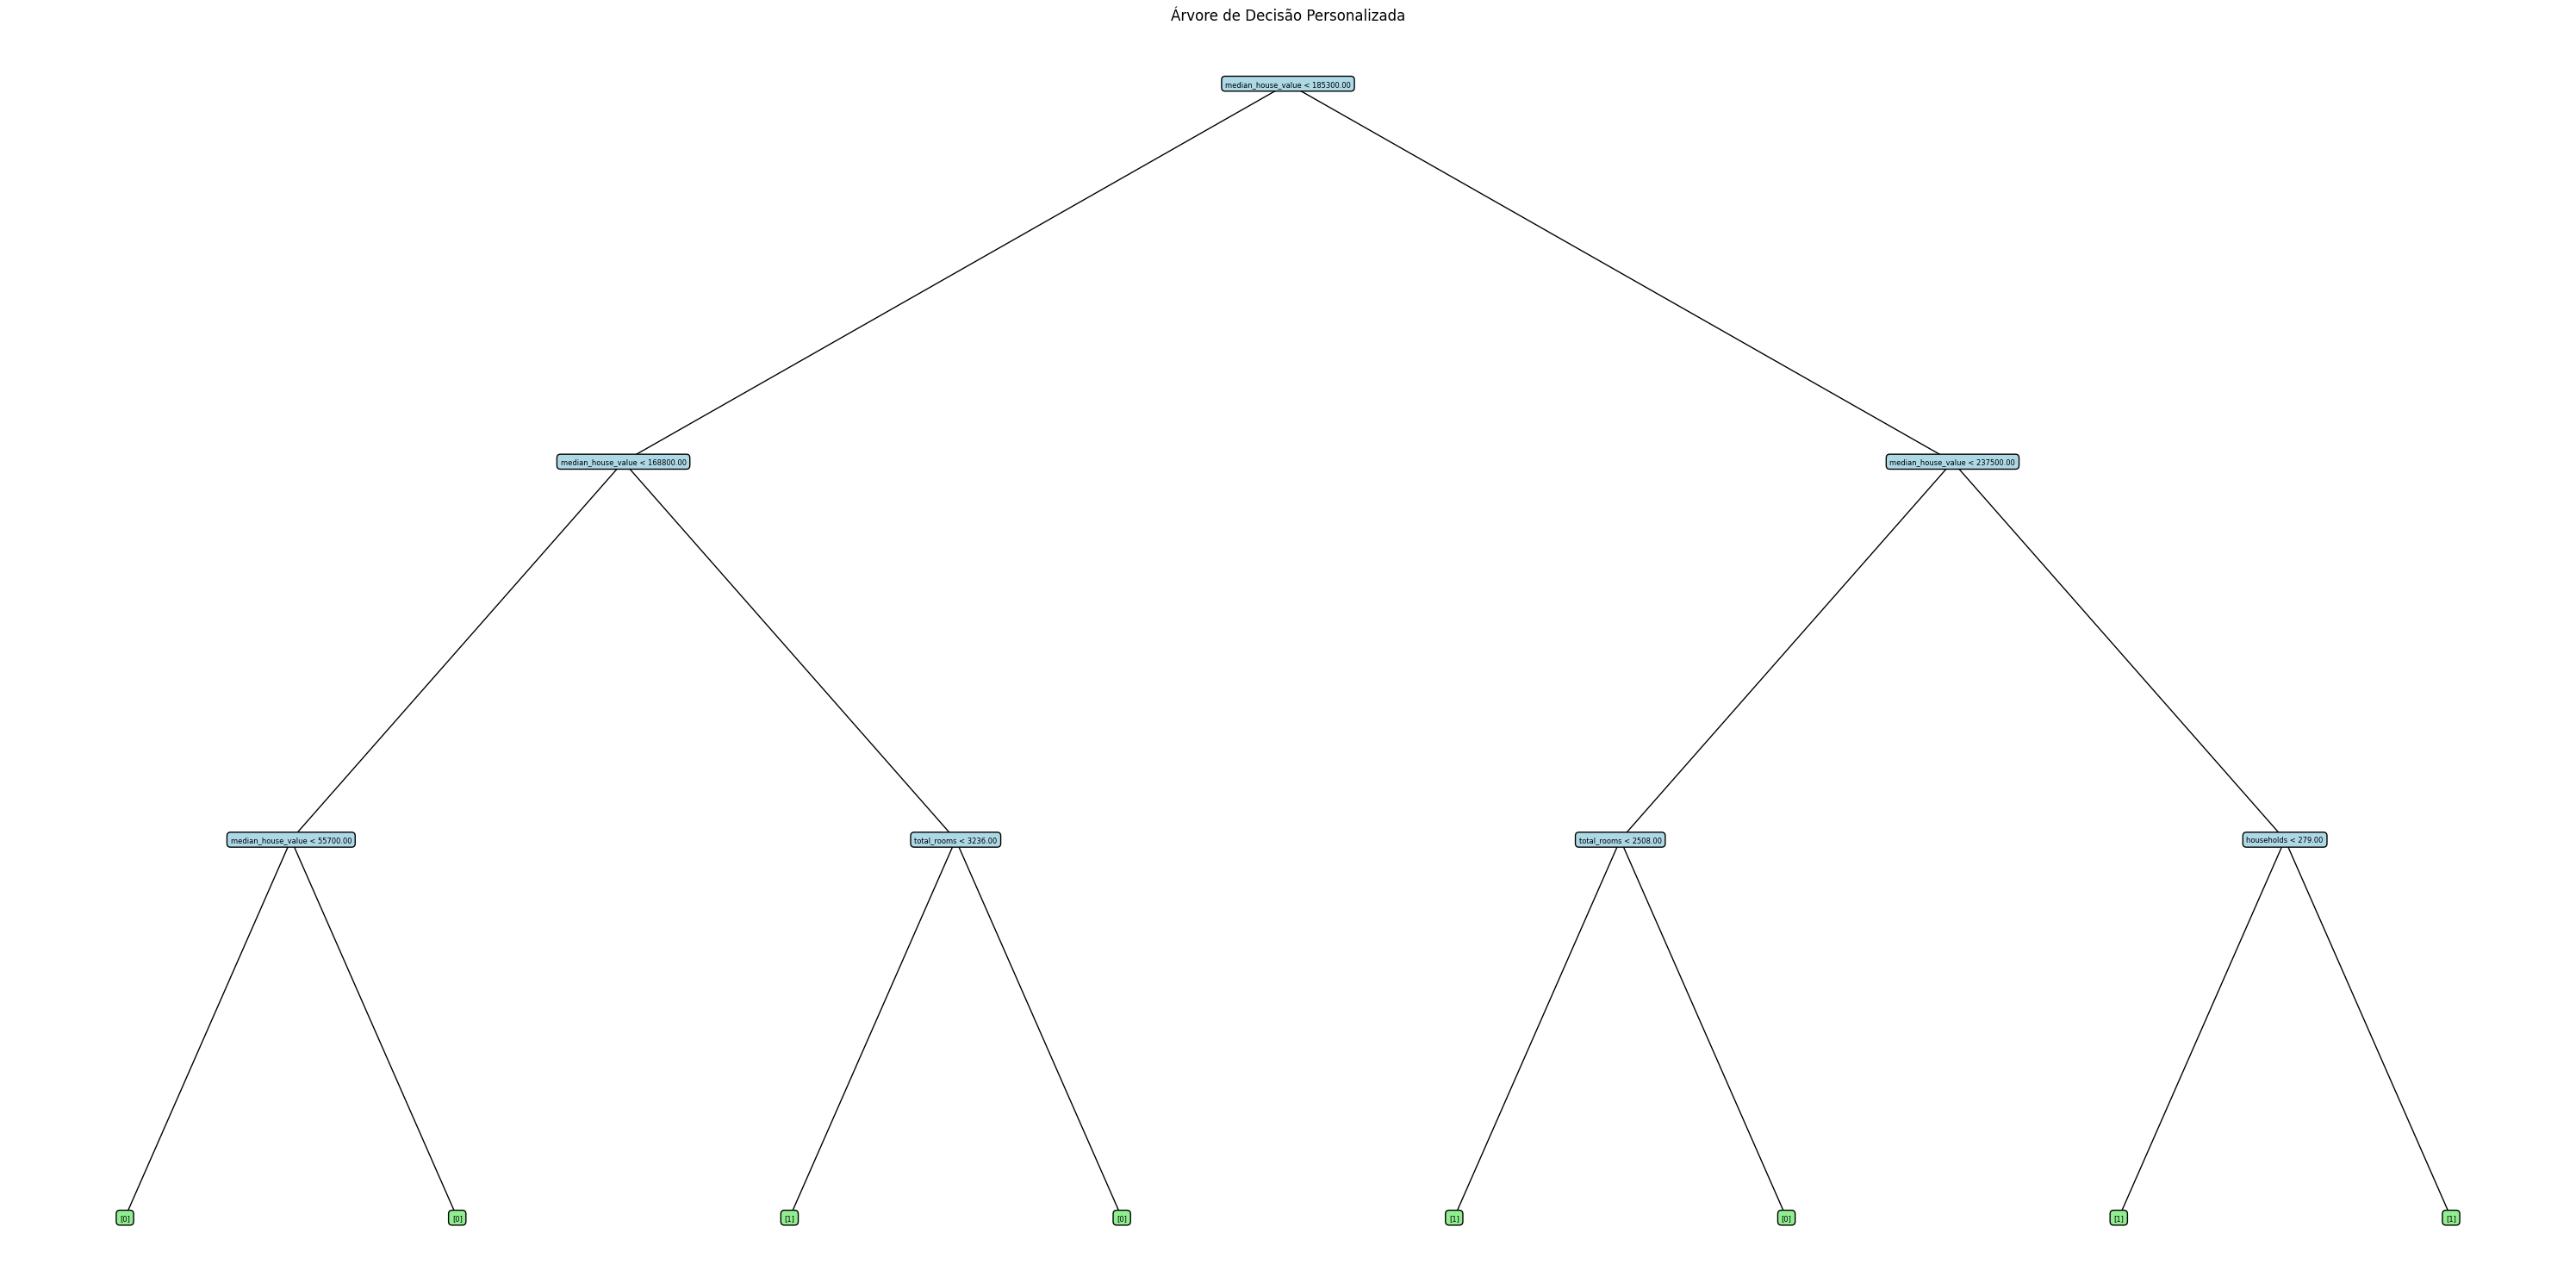


Árvore com Poda por Custo-Complexidade (alpha=0.01):


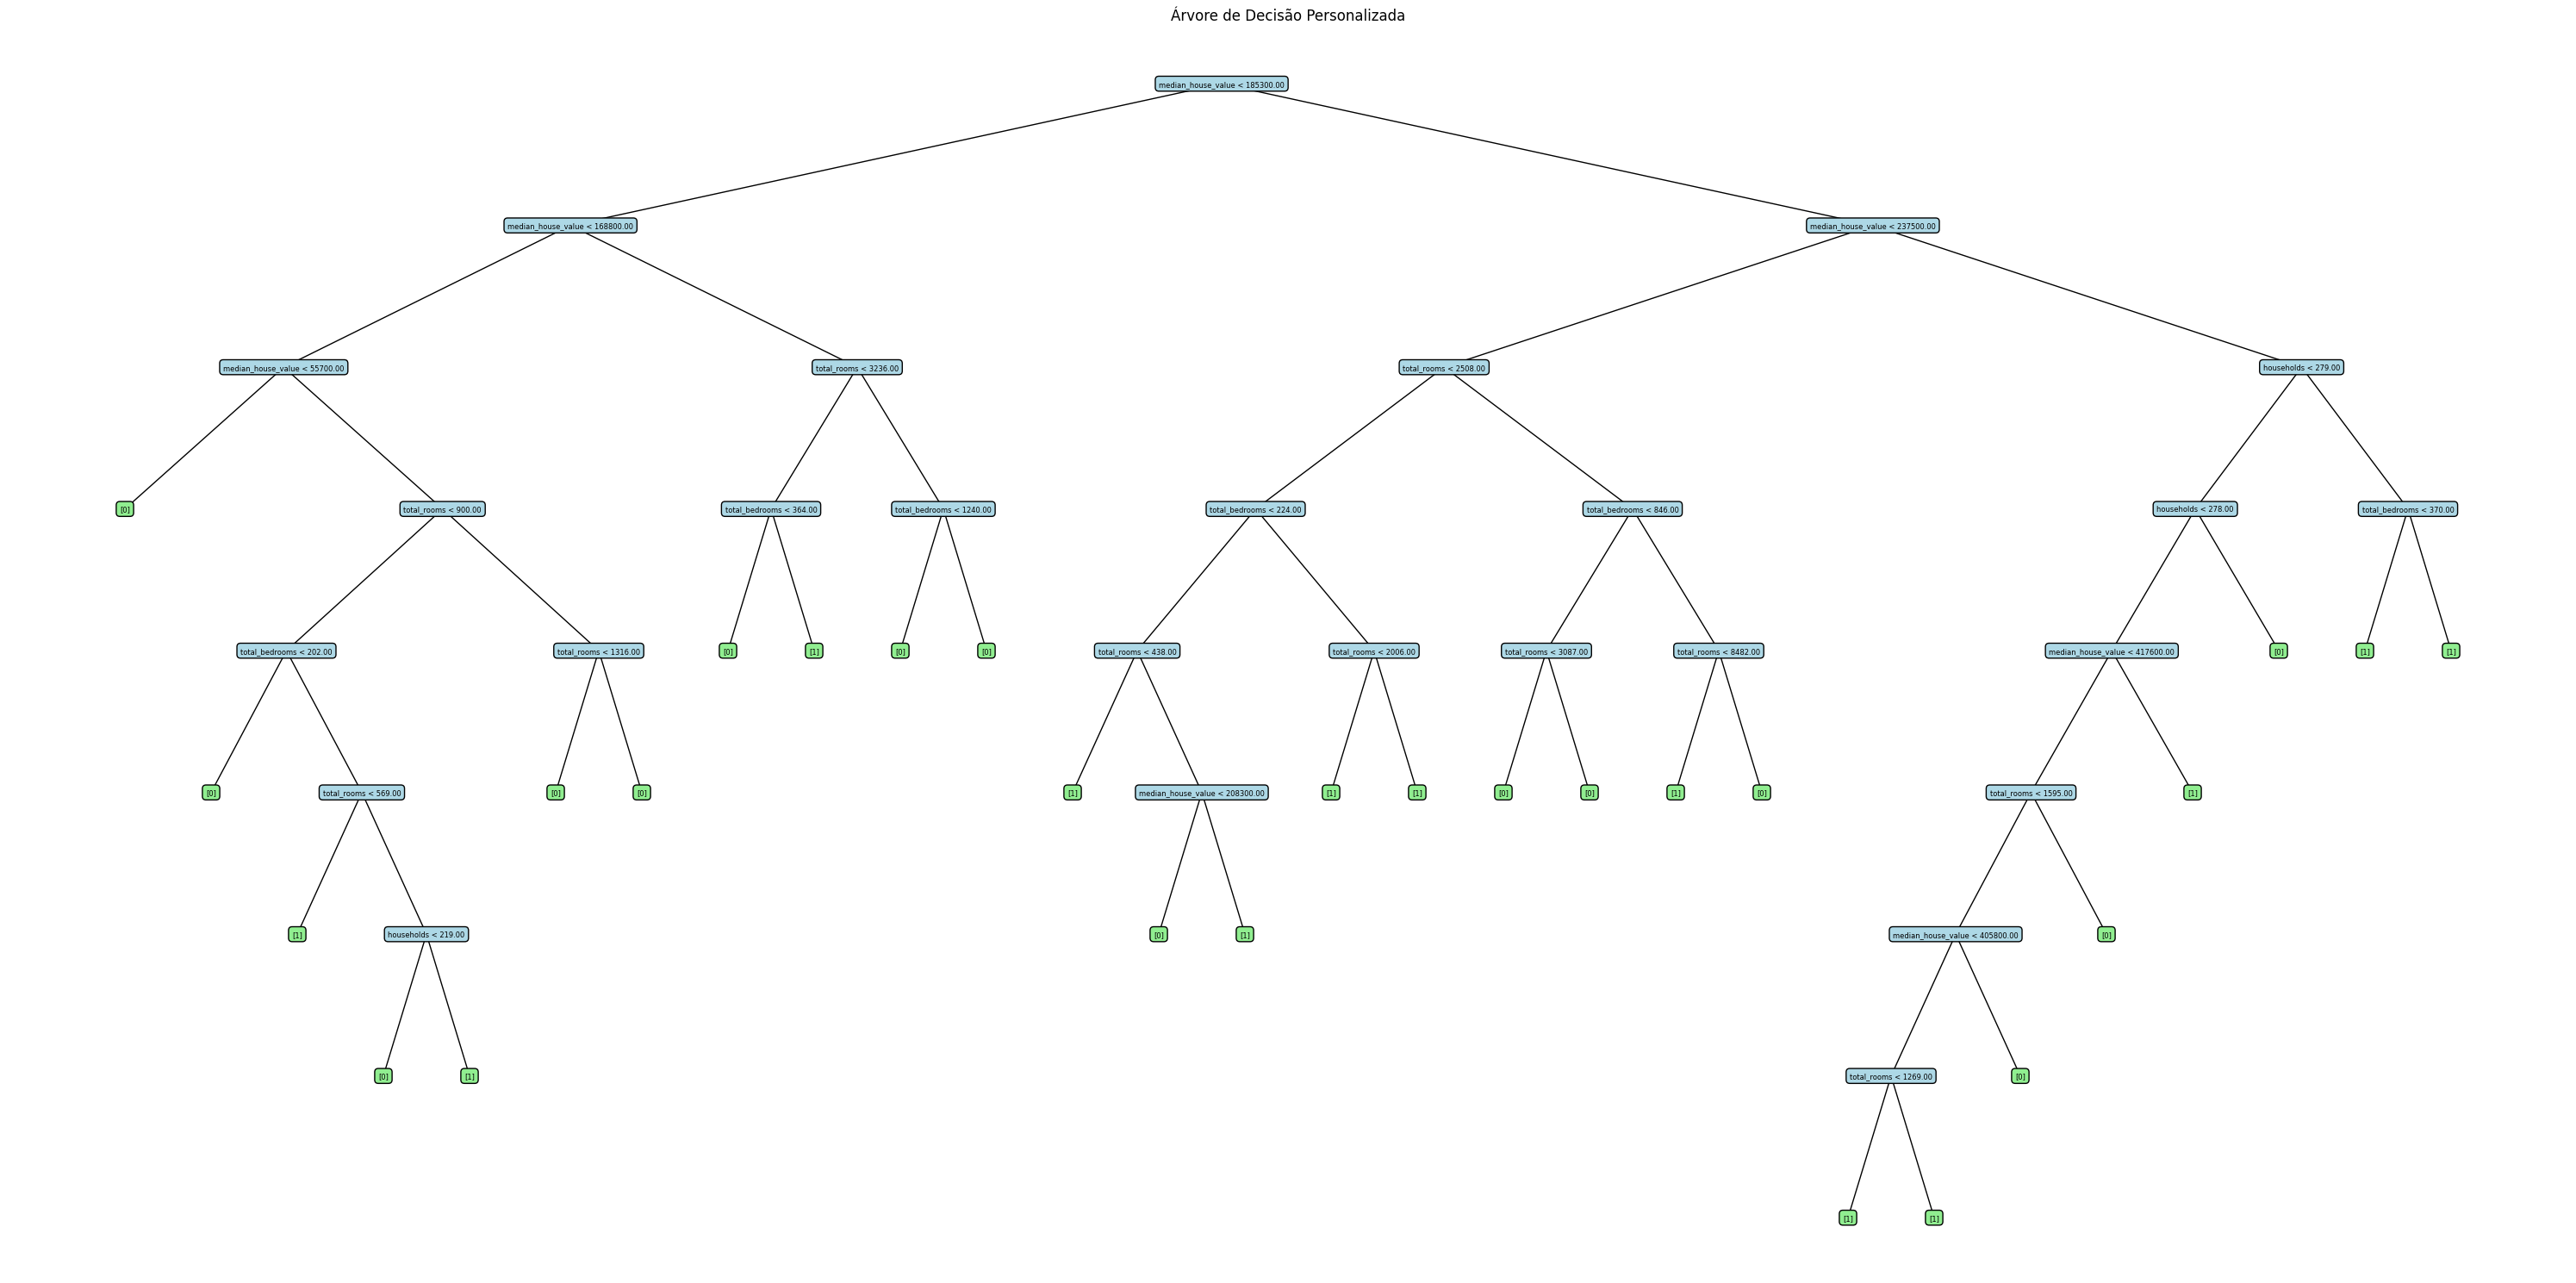


Árvore com Poda Híbrida:


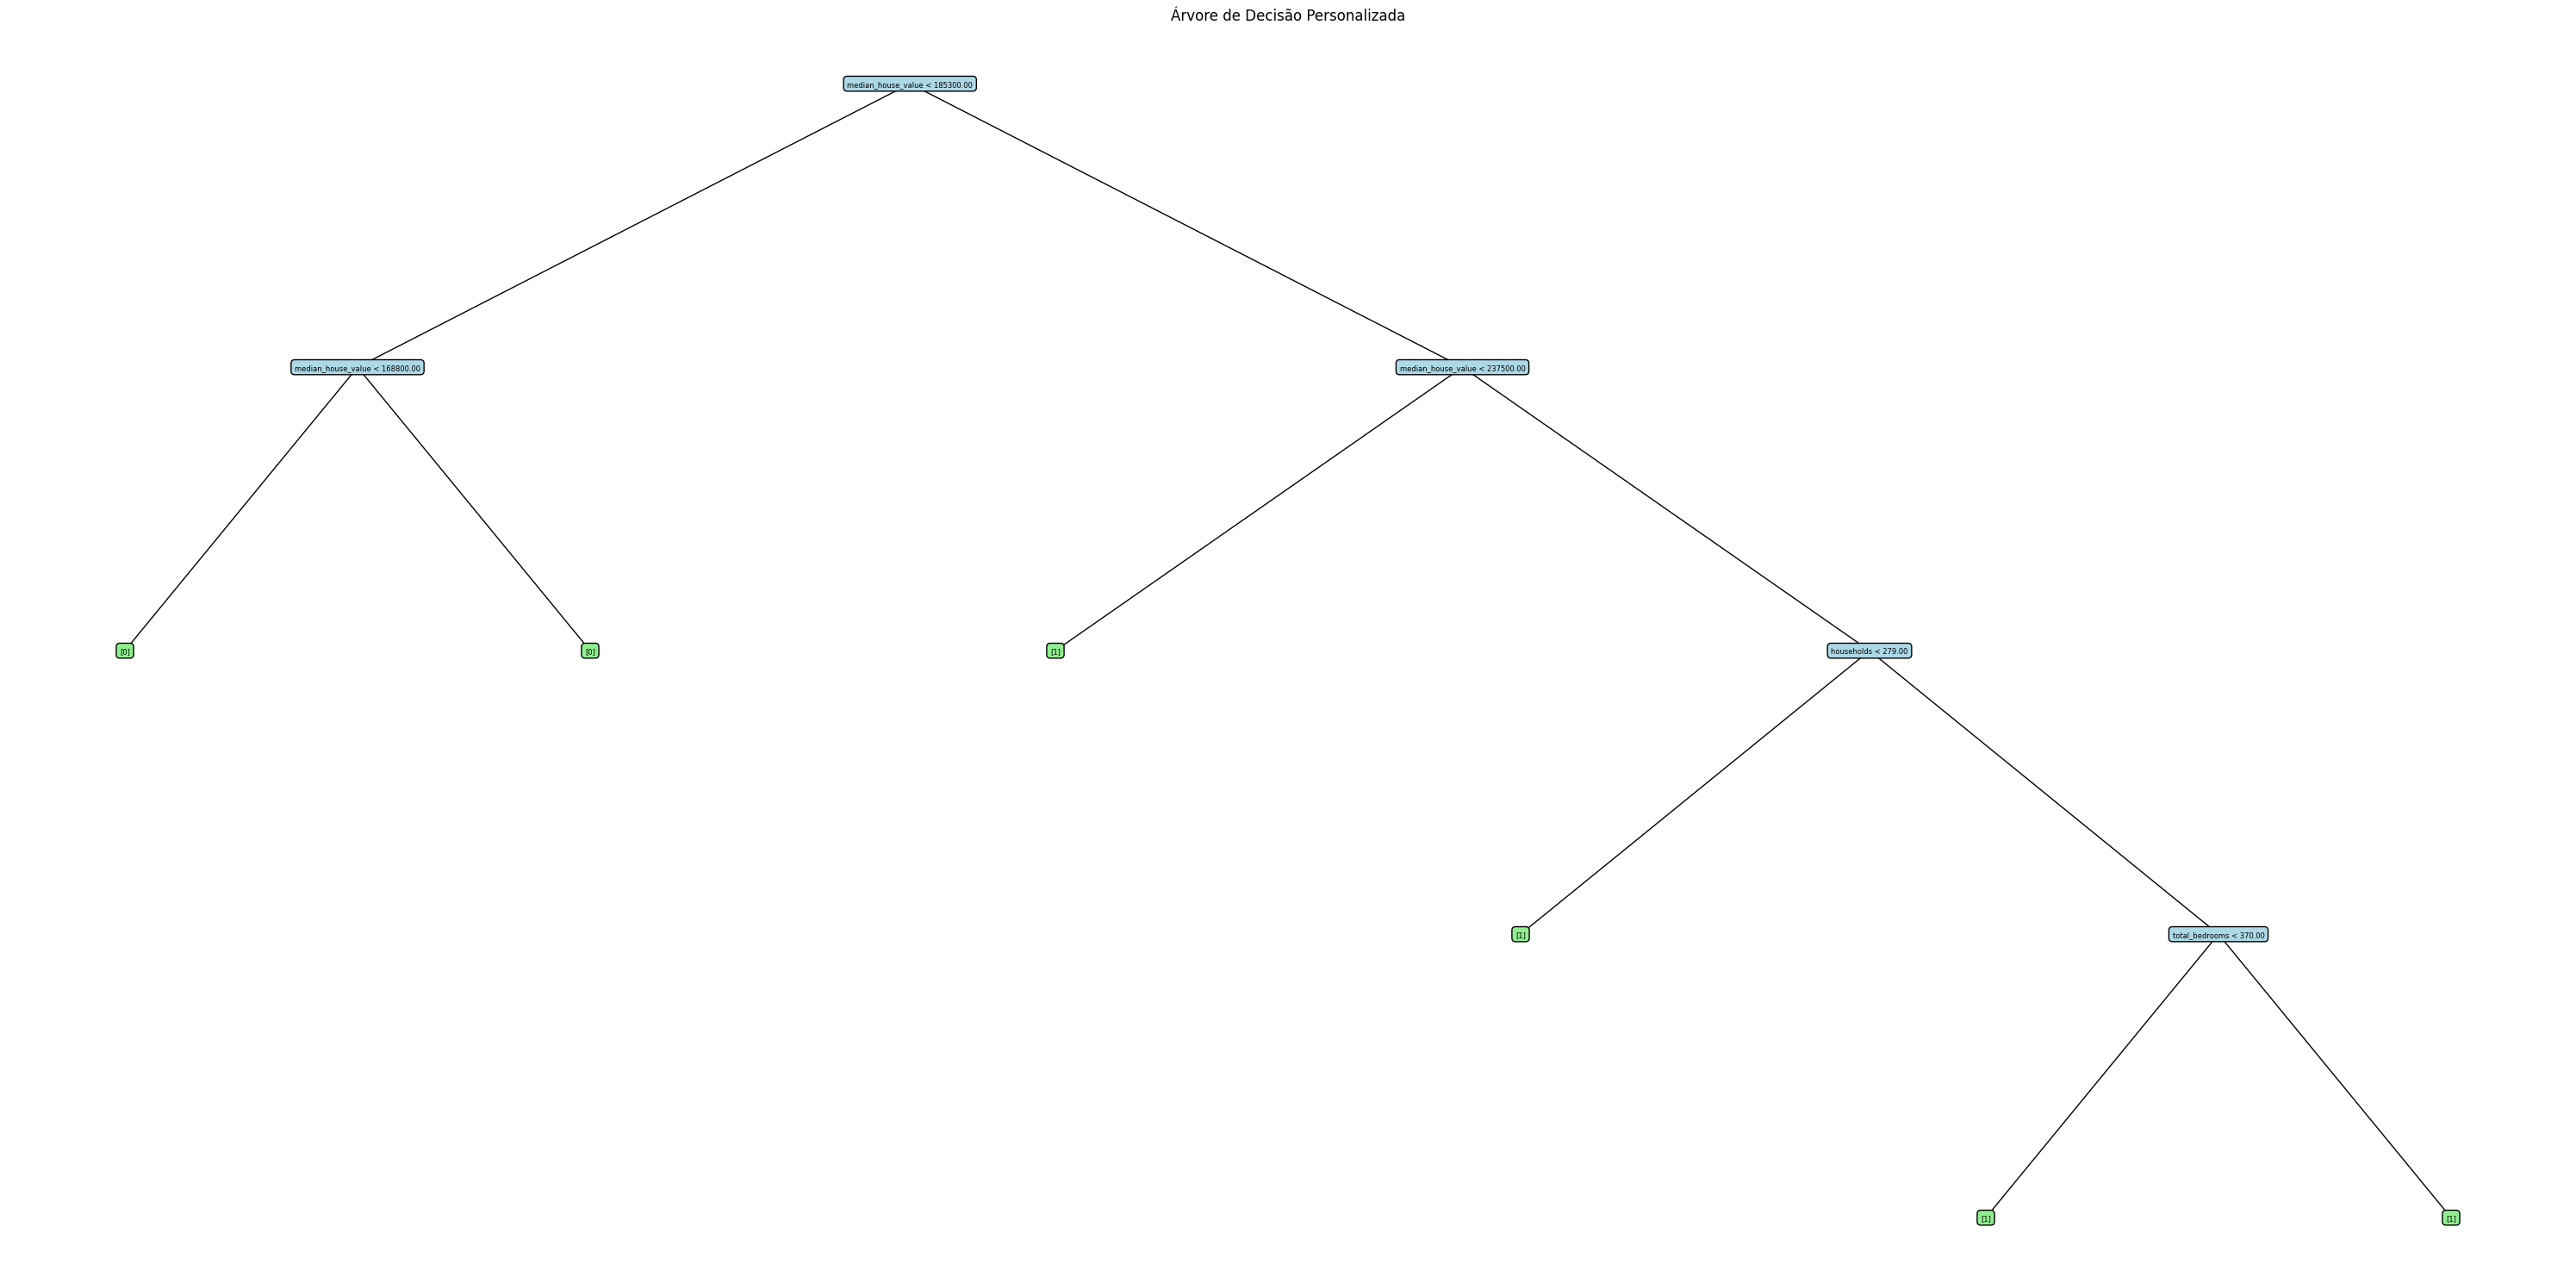

In [36]:
# Gerar e salvar todas as árvores podadas como arquivos JSON

print("\n=== GERANDO E SALVANDO ÁRVORES PODADAS ===")

# Gerar todas as versões
arvores_podadas = salvar_arvores_podadas(X_train, y_train, X_val, y_val, feature_names, "housing")

print("\n=== VISUALIZANDO ALGUMAS ÁRVORES PODADAS ===")

# Visualizar árvore com poda por profundidade (depth=3)
print("\nÁrvore com Poda por Profundidade (depth=3):")
raiz_prof3 = construir_arvore(X_train, y_train, min_samples_leaf=1)
poda_profundidade(raiz_prof3, 3)
plotar_arvore_dinamica(raiz_prof3, feature_names)

# Visualizar árvore com poda por custo-complexidade (alpha=0.01)
print("\nÁrvore com Poda por Custo-Complexidade (alpha=0.01):")
raiz_cc = construir_arvore(X_train, y_train, min_samples_leaf=1)
poda_custo_complexidade(raiz_cc, 0.01)
plotar_arvore_dinamica(raiz_cc, feature_names)

# Visualizar árvore híbrida
print("\nÁrvore com Poda Híbrida:")
raiz_hibrida_viz = construir_arvore(X_train, y_train, min_samples_leaf=1)
poda_hibrida(raiz_hibrida_viz, X_val, y_val, alpha=0.01, max_depth=4, min_samples=10)
plotar_arvore_dinamica(raiz_hibrida_viz, feature_names)

=== ANÁLISE COMPARATIVA DETALHADA ===
                        Método  Acc_Train  Acc_Val  Diferença_Acc  Total_Nós  Folhas  Profundidade
                      original      1.000    0.876         -0.124         77      39             9
                     validacao      0.990    0.919         -0.071         67      34             8
custo_complexidade_alpha_0.001      0.975    0.930         -0.045         55      28             8
 custo_complexidade_alpha_0.01      0.975    0.930         -0.045         55      28             8
  custo_complexidade_alpha_0.1      0.975    0.930         -0.045         55      28             8
                profundidade_2      0.945    0.950          0.005          7       4             2
                profundidade_3      0.953    0.942         -0.011         15       8             3
                profundidade_4      0.965    0.946         -0.019         31      16             4
                profundidade_5      0.977    0.915         -0.062      

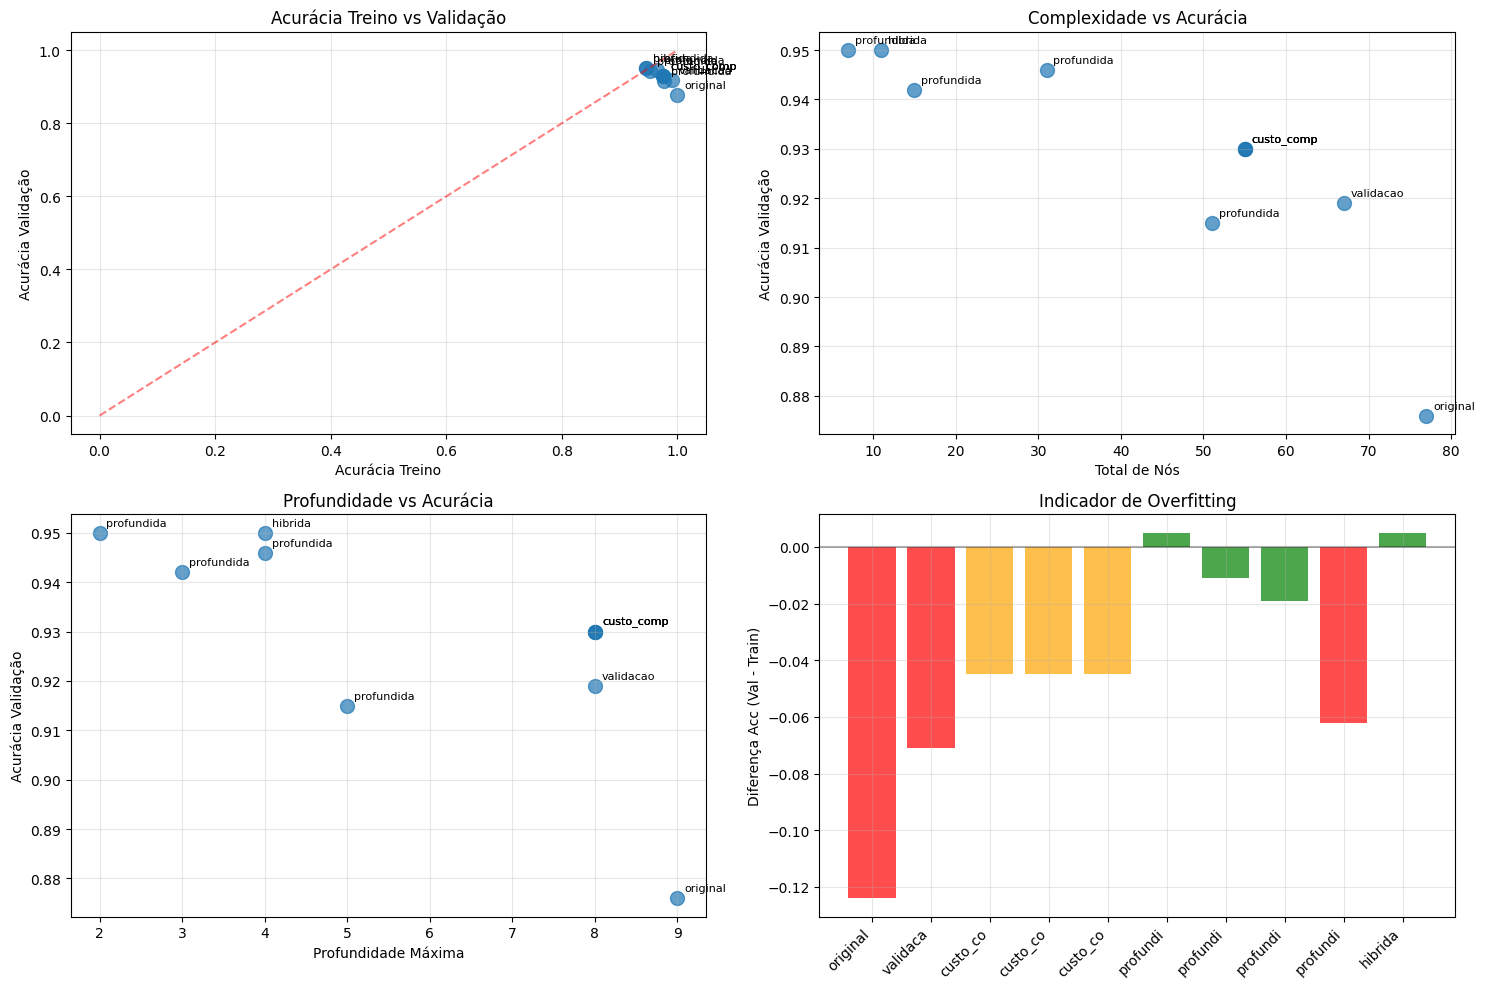


=== ANÁLISE CONCLUÍDA ===
Arquivos gerados:
- housing_*.json: Estruturas das árvores podadas
- analise_podas_housing.csv: Análise comparativa
- resumo_podas_housing.json: Resumo completo com melhores modelos


In [37]:
# Análise comparativa detalhada e exportação de resumo

def contar_nos(no):
    """Conta o número total de nós na árvore"""
    if no.is_leaf:
        return 1
    return 1 + contar_nos(no.left) + contar_nos(no.right)

def contar_folhas(no):
    """Conta o número de folhas na árvore"""
    if no.is_leaf:
        return 1
    return contar_folhas(no.left) + contar_folhas(no.right)

def profundidade_maxima(no):
    """Calcula a profundidade máxima da árvore"""
    if no.is_leaf:
        return 0
    return 1 + max(profundidade_maxima(no.left), profundidade_maxima(no.right))

# Criar análise comparativa
resultados = []

for nome, dados in arvores_podadas.items():
    arvore = dados['tree']
    resultado = {
        'Método': nome,
        'Acc_Train': dados['acc_train'],
        'Acc_Val': dados['acc_val'],
        'Diferença_Acc': dados['acc_val'] - dados['acc_train'],  # Generalização
        'Total_Nós': contar_nos(arvore),
        'Folhas': contar_folhas(arvore),
        'Profundidade': profundidade_maxima(arvore)
    }
    resultados.append(resultado)

# Criar DataFrame com resultados
df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.round(3)

print("=== ANÁLISE COMPARATIVA DETALHADA ===")
print(df_resultados.to_string(index=False))

# Identificar melhor modelo
melhor_val = df_resultados.loc[df_resultados['Acc_Val'].idxmax()]
melhor_generalizacao = df_resultados.loc[df_resultados['Diferença_Acc'].abs().idxmin()]
menor_complexidade = df_resultados.loc[df_resultados['Total_Nós'].idxmin()]

print("\n=== MELHORES MODELOS ===")
print(f"Melhor Acurácia Validação: {melhor_val['Método']} ({melhor_val['Acc_Val']:.3f})")
print(f"Melhor Generalização: {melhor_generalizacao['Método']} (diff: {melhor_generalizacao['Diferença_Acc']:.3f})")
print(f"Menor Complexidade: {menor_complexidade['Método']} ({menor_complexidade['Total_Nós']} nós)")

# Salvar análise como CSV e JSON
df_resultados.to_csv("analise_podas_housing.csv", index=False)
print("\nAnálise salva em: analise_podas_housing.csv")

# Criar resumo em JSON
resumo = {
    "dataset": "housing",
    "tamanho_treino": len(X_train),
    "tamanho_validacao": len(X_val),
    "features": feature_names,
    "melhores_modelos": {
        "melhor_acuracia_validacao": {
            "metodo": melhor_val['Método'],
            "acuracia": float(melhor_val['Acc_Val']),
            "nos": int(melhor_val['Total_Nós'])
        },
        "melhor_generalizacao": {
            "metodo": melhor_generalizacao['Método'],
            "diferenca_acc": float(melhor_generalizacao['Diferença_Acc']),
            "nos": int(melhor_generalizacao['Total_Nós'])
        },
        "menor_complexidade": {
            "metodo": menor_complexidade['Método'],
            "nos": int(menor_complexidade['Total_Nós']),
            "acuracia": float(menor_complexidade['Acc_Val'])
        }
    },
    "todos_resultados": df_resultados.to_dict('records')
}

with open("resumo_podas_housing.json", "w") as f:
    json.dump(resumo, f, default=converter, indent=2)

print("Resumo completo salvo em: resumo_podas_housing.json")

# Plotar comparação visual
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Acurácia Train vs Val
ax1.scatter(df_resultados['Acc_Train'], df_resultados['Acc_Val'], s=100, alpha=0.7)
for i, txt in enumerate(df_resultados['Método']):
    ax1.annotate(txt[:10], (df_resultados['Acc_Train'].iloc[i], df_resultados['Acc_Val'].iloc[i]), 
                xytext=(5, 5), textcoords='offset points', fontsize=8)
ax1.plot([0, 1], [0, 1], 'r--', alpha=0.5)
ax1.set_xlabel('Acurácia Treino')
ax1.set_ylabel('Acurácia Validação')
ax1.set_title('Acurácia Treino vs Validação')
ax1.grid(True, alpha=0.3)

# Complexidade vs Acurácia
ax2.scatter(df_resultados['Total_Nós'], df_resultados['Acc_Val'], s=100, alpha=0.7)
for i, txt in enumerate(df_resultados['Método']):
    ax2.annotate(txt[:10], (df_resultados['Total_Nós'].iloc[i], df_resultados['Acc_Val'].iloc[i]), 
                xytext=(5, 5), textcoords='offset points', fontsize=8)
ax2.set_xlabel('Total de Nós')
ax2.set_ylabel('Acurácia Validação')
ax2.set_title('Complexidade vs Acurácia')
ax2.grid(True, alpha=0.3)

# Profundidade vs Acurácia
ax3.scatter(df_resultados['Profundidade'], df_resultados['Acc_Val'], s=100, alpha=0.7)
for i, txt in enumerate(df_resultados['Método']):
    ax3.annotate(txt[:10], (df_resultados['Profundidade'].iloc[i], df_resultados['Acc_Val'].iloc[i]), 
                xytext=(5, 5), textcoords='offset points', fontsize=8)
ax3.set_xlabel('Profundidade Máxima')
ax3.set_ylabel('Acurácia Validação')
ax3.set_title('Profundidade vs Acurácia')
ax3.grid(True, alpha=0.3)

# Diferença de Acurácia (Overfitting)
colors = ['red' if x > 0.05 else 'orange' if x > 0.02 else 'green' for x in df_resultados['Diferença_Acc'].abs()]
ax4.bar(range(len(df_resultados)), df_resultados['Diferença_Acc'], color=colors, alpha=0.7)
ax4.set_xticks(range(len(df_resultados)))
ax4.set_xticklabels([m[:8] for m in df_resultados['Método']], rotation=45, ha='right')
ax4.set_ylabel('Diferença Acc (Val - Train)')
ax4.set_title('Indicador de Overfitting')
ax4.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n=== ANÁLISE CONCLUÍDA ===")
print("Arquivos gerados:")
print("- housing_*.json: Estruturas das árvores podadas")
print("- analise_podas_housing.csv: Análise comparativa")
print("- resumo_podas_housing.json: Resumo completo com melhores modelos")